In [17]:
import random
import imageio
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model

## Misc

In [18]:
# todo: apply to classes
def make_trainable(net, val, lr=0.001):
    net.model.trainable = val
    for l in net.model.layers:
        l.trainable = val
    net.cmpile(lr)
    
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # при замене оптимизатора всё слетает ???
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def fit_discriminator(discriminator, Data, epochs, lr=0.001):
    make_trainable(discriminator, True, lr=lr)
    #discriminator.trainable = True
    discriminator.fit(Data.x, Data.y, epochs=epochs, plot=True)
    
# Training GAN
def fit_gan(gan, Data, epochs):
    p = Plot('GAN_results')

    for i in range(epochs):
        V = Data.load_random(n_samples=64)
        print("Epoch %d" % i)
        generated = generator.predict(V)
        if i % 10 == 0:
            p.add_to_gif(generated, np.ones(V.shape[0]), title='Epoch %d' % i, alpha=1)
        #make_trainable(discriminator, False)
        print("Fitting GAN")
        gan.fit(V, np.ones(V.shape[0]), epochs=2)
        #make_trainable(discriminator, True)
        print("Fitting discriminator")
        discriminator.fit(generated, np.zeros(V.shape[0]), validation_split=None)
        discriminator.fit(Data.x, Data.y, validation_split=0.2)
    p.save_gif()
    gan.save('gan.h5')


## Data generation class

In [19]:
# To generate data
class Dataset():
    x = None
    y = None
    W = None
    
    def __init__(self):
        return
    
    def load_data(self, data_range=10):
        dots_x = []
        for i in range(data_range*20):
            x = random.uniform(-data_range, data_range)
            dots_x.append((x, x**2)) # square
            for j in range(7):
                dots_x.append((x, random.uniform(-2*data_range, 1.5*data_range**2)))
        dots_x = np.array(dots_x)
        #dots_y = np.array([random.uniform(0.75, 1.2) if x[0]**2 == x[1] else random.uniform(0, 0.3) for x in dots_x])
        dots_y = np.array([1 if x[0]**2 == x[1] else 0 for x in dots_x])
        self.x, self.y = dots_x, dots_y
        return dots_x, dots_y
    
    def load_weights(self, default_weight=0.12):
        W = self.y.copy().astype(float)
        W[W == 0] = 0.12
        self.W = W
        return W
        
    @staticmethod
    def load_random(n_dim=5, n_samples=16):
        V = np.random.normal(size=(n_samples, n_dim))
        return V
    

## Image plotting class

In [20]:
# To plot images
class Plot:
    name = ""
    images = []
    threshold = 0.0
    
    def __init__(self, name, threshold=0.6):
        self.name = name
        self.threshold = threshold
        self.images = []
    
    @staticmethod
    def parabola_plot(ax, xrange):
        x = np.linspace(xrange, 1)
        y = x*x
        plt.plot(x, y)
    
    @staticmethod
    def dots_plot(ax, dots_x, dots_y, color):
        ax.scatter(dots_x, dots_y, color=color, alpha=0.15)
        plt.plot()
    
    def picture(self, dots, predictions, title='', alpha=0.3):
        predictions = predictions.reshape(predictions.shape[0])
        dots_x = dots.T[0]
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.set(title=title)
        #ax2 = ax1.twinx()
        plt.grid(axis='both')
        xrange = (dots_x.min(), dots_x.max())
        self.parabola_plot(ax1, xrange)
        ax1.scatter(dots.T[0], dots.T[1], c=predictions, cmap='YlOrRd', alpha=alpha)
        
    def add_to_gif(self, dots_x, predictions, title='', alpha=0.3):
        self.picture(dots_x, predictions, title=title, alpha=alpha)
        plt.savefig(self.name+'.png')
        plt.close()
        image = Image.open(self.name+'.png')
        ar = np.asarray(image)
        self.images.append(ar)
        
    def save_gif(self):
        kargs = { 'duration': 0.2 }
        imageio.mimsave(self.name+'.gif', self.images, None, **kargs)
        

## Neural networks classes

In [21]:
# Classes for neural networks

# Generator
class Gen:
    model = None
    
    def __init__(self):
        model = Sequential([Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=5),
                            Dense(2, activation='linear')
        ])
        self.model = model
        
    def predict(self, dots_x):
        return self.model.predict(dots_x)
    
    def cmpile(self):
        return
    
# Discriminator
class Dsc:
    model = None
    
    def __init__(self):
        model = Sequential([Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=2),
                            Dense(1, activation='sigmoid')
        ])
        self.model = model
    
    def cmpile(self, lr=0.0001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics=['accuracy'])
        
    def fit(self, dots_x, dots_y, weights=None, epochs=1, validation_split=0.15, plot=False):
        if plot:
            img = Plot('discriminator_fit')
            for i in range(epochs):
                print("Epoch %d out of %d" % (i, epochs))
                self.model.fit(dots_x, 
                               dots_y, 
                               epochs=10, 
                               sample_weight=weights,
                               validation_split=validation_split)
                img.add_to_gif(dots_x, self.model.predict(dots_x), title='Epoch %d' % i)
            img.save_gif()                        
        else:
            self.model.fit(dots_x, 
                           dots_y, 
                           epochs=epochs, 
                           sample_weight=weights, 
                           validation_split=validation_split)
    
    def save(self, name='discriminator'):
        self.model.save(name+'.h5')
        

# # Raw classes, don't work 

```python
class Gan:
    gen = None
    dsc = None
    model = None
    
    def __init__(self, gen, dsc, n_dim=5):
        make_trainable(dsc, False)
        self.gen = gen
        self.dsc = dsc
        # connect them
        model = Sequential()
        # add generator
        model.add(gen.model)
        # add the discriminator
        model.add(dsc.model)
        self.model = model
    
    # This method doesn't work
    # Presumably because of some optimizer issue
    def cmpile(self, lr=0.001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics = ['accuracy'])
        
    def fit(self, dots_x, dots_y, epochs=1):
        self.model.fit(dots_x, dots_y, epochs=epochs)
        
class Dummy:
    model = None
    
    def __init__(self, model):
        self.model = model
        
    def cmpile(self, lr=0.0001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics=['accuracy'])
    
    # todo: remove hardcode
    def fit(self, dots_x, dots_y, weights=None, epochs=1, validation_split=0.15, plot=False):
        if plot:
            img = Plot('discriminator_fit')
            for i in range(epochs//25):
                print("Epoch %d out of %d" % (i, epochs))
                self.model.fit(dots_x, 
                               dots_y, 
                               epochs=25, 
                               sample_weight=weights)
                img.add_to_gif(dots_x, self.model.predict(dots_x), title='Epoch %d' % i*25)
            img.save_gif()                        
        else:
            self.model.fit(dots_x, 
                           dots_y, 
                           epochs=epochs, 
                           sample_weight=weights, 
                           validation_split=validation_split)
    
    def save(self, name='discriminator'):
        self.model.save(name+'.h5')
```

In [22]:
#discriminator = tf.keras.models.load_model('discriminator.h5')

# Start Here

In [23]:
# Generating data
Data = Dataset()
Data.load_data(data_range=10)
weights = Data.load_weights()

# Defining neural networks
generator = Gen()
discriminator = Dsc()


In [24]:
fit_discriminator(discriminator, Data, 900, lr=0.001)

Epoch 0 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 1s 469us/sample - loss: 46.1928 - acc: 0.1544 - val_loss: 19.7359 - val_acc: 0.1875
Epoch 2/10
1360/1360 [==============================] - 0s 203us/sample - loss: 5.5493 - acc: 0.5243 - val_loss: 0.7837 - val_acc: 0.8542
Epoch 3/10
1360/1360 [==============================] - 0s 246us/sample - loss: 0.7197 - acc: 0.8493 - val_loss: 0.5506 - val_acc: 0.8708
Epoch 4/10
1360/1360 [==============================] - 0s 223us/sample - loss: 0.4436 - acc: 0.8493 - val_loss: 0.3546 - val_acc: 0.8625
Epoch 5/10
1360/1360 [==============================] - 0s 213us/sample - loss: 0.3538 - acc: 0.8515 - val_loss: 0.3499 - val_acc: 0.8625
Epoch 6/10
1360/1360 [==============================] - 0s 219us/sample - loss: 0.3459 - acc: 0.8537 - val_loss: 0.3457 - val_acc: 0.8625
Epoch 7/10
1360/1360 [==============================] - 0s 297us/sample - loss: 0.3439 - acc: 0.8551 - v

1360/1360 [==============================] - 0s 241us/sample - loss: 0.2944 - acc: 0.8904 - val_loss: 0.2659 - val_acc: 0.9000
Epoch 4/10
1360/1360 [==============================] - 0s 169us/sample - loss: 0.2774 - acc: 0.8875 - val_loss: 0.3041 - val_acc: 0.8958
Epoch 5/10
1360/1360 [==============================] - 0s 264us/sample - loss: 0.2801 - acc: 0.8897 - val_loss: 0.2839 - val_acc: 0.8958
Epoch 6/10
1360/1360 [==============================] - 0s 232us/sample - loss: 0.2758 - acc: 0.8868 - val_loss: 0.2652 - val_acc: 0.9000
Epoch 7/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.2698 - acc: 0.8912 - val_loss: 0.2746 - val_acc: 0.9042
Epoch 8/10
1360/1360 [==============================] - 0s 253us/sample - loss: 0.2735 - acc: 0.8904 - val_loss: 0.2621 - val_acc: 0.9000
Epoch 9/10
1360/1360 [==============================] - 0s 229us/sample - loss: 0.2723 - acc: 0.8897 - val_loss: 0.2615 - val_acc: 0.9042
Epoch 10/10
1360/1360 [======================

Epoch 10/10
1360/1360 [==============================] - 0s 221us/sample - loss: 0.2804 - acc: 0.9015 - val_loss: 0.2735 - val_acc: 0.9167
Epoch 17 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 215us/sample - loss: 0.2994 - acc: 0.9015 - val_loss: 0.2525 - val_acc: 0.9208
Epoch 2/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.2706 - acc: 0.9125 - val_loss: 0.2530 - val_acc: 0.9208
Epoch 3/10
1360/1360 [==============================] - 0s 232us/sample - loss: 0.2667 - acc: 0.9066 - val_loss: 0.2545 - val_acc: 0.9208
Epoch 4/10
1360/1360 [==============================] - 0s 225us/sample - loss: 0.2630 - acc: 0.9088 - val_loss: 0.2713 - val_acc: 0.9208
Epoch 5/10
1360/1360 [==============================] - 0s 234us/sample - loss: 0.2675 - acc: 0.9081 - val_loss: 0.2687 - val_acc: 0.9208
Epoch 6/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.2632 - acc: 0.9074 - v

1360/1360 [==============================] - 0s 254us/sample - loss: 0.2782 - acc: 0.9022 - val_loss: 0.3734 - val_acc: 0.9125
Epoch 3/10
1360/1360 [==============================] - 0s 258us/sample - loss: 0.2888 - acc: 0.9096 - val_loss: 0.2468 - val_acc: 0.9208
Epoch 4/10
1360/1360 [==============================] - 0s 227us/sample - loss: 0.2658 - acc: 0.9125 - val_loss: 0.2984 - val_acc: 0.9167
Epoch 5/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.2885 - acc: 0.9066 - val_loss: 0.2348 - val_acc: 0.9250
Epoch 6/10
1360/1360 [==============================] - 0s 241us/sample - loss: 0.2569 - acc: 0.9051 - val_loss: 0.2492 - val_acc: 0.9208
Epoch 7/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.2541 - acc: 0.9081 - val_loss: 0.2342 - val_acc: 0.9250
Epoch 8/10
1360/1360 [==============================] - 0s 325us/sample - loss: 0.2600 - acc: 0.9066 - val_loss: 0.2397 - val_acc: 0.9208
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 239us/sample - loss: 0.2618 - acc: 0.9059 - val_loss: 0.3240 - val_acc: 0.9167
Epoch 10/10
1360/1360 [==============================] - 0s 239us/sample - loss: 0.2796 - acc: 0.9096 - val_loss: 0.2297 - val_acc: 0.9250
Epoch 34 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.2531 - acc: 0.9110 - val_loss: 0.2409 - val_acc: 0.9292
Epoch 2/10
1360/1360 [==============================] - 0s 217us/sample - loss: 0.2603 - acc: 0.9118 - val_loss: 0.2504 - val_acc: 0.9208
Epoch 3/10
1360/1360 [==============================] - 0s 223us/sample - loss: 0.2805 - acc: 0.9051 - val_loss: 0.2287 - val_acc: 0.9292
Epoch 4/10
1360/1360 [==============================] - 0s 241us/sample - loss: 0.2478 - acc: 0.9103 - val_loss: 0.2288 - val_acc: 0.9333
Epoch 5/10
1360/1360 [==============================] - 0s 231us/sample - loss: 0.2541 - acc: 0.9125 - v

1360/1360 [==============================] - 0s 223us/sample - loss: 0.1895 - acc: 0.9250 - val_loss: 0.2101 - val_acc: 0.9125
Epoch 2/10
1360/1360 [==============================] - 0s 331us/sample - loss: 0.1893 - acc: 0.9316 - val_loss: 0.1728 - val_acc: 0.9292
Epoch 3/10
1360/1360 [==============================] - 0s 261us/sample - loss: 0.1842 - acc: 0.9250 - val_loss: 0.1722 - val_acc: 0.9417
Epoch 4/10
1360/1360 [==============================] - 0s 270us/sample - loss: 0.1852 - acc: 0.9331 - val_loss: 0.1990 - val_acc: 0.9125
Epoch 5/10
1360/1360 [==============================] - 0s 239us/sample - loss: 0.1827 - acc: 0.9353 - val_loss: 0.1729 - val_acc: 0.9333
Epoch 6/10
1360/1360 [==============================] - 0s 204us/sample - loss: 0.1895 - acc: 0.9250 - val_loss: 0.1743 - val_acc: 0.9375
Epoch 7/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1904 - acc: 0.9221 - val_loss: 0.1764 - val_acc: 0.9333
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 215us/sample - loss: 0.1683 - acc: 0.9309 - val_loss: 0.1676 - val_acc: 0.9208
Epoch 9/10
1360/1360 [==============================] - 0s 210us/sample - loss: 0.1649 - acc: 0.9309 - val_loss: 0.1672 - val_acc: 0.9083
Epoch 10/10
1360/1360 [==============================] - 0s 202us/sample - loss: 0.1725 - acc: 0.9257 - val_loss: 0.1622 - val_acc: 0.9250
Epoch 51 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 210us/sample - loss: 0.1644 - acc: 0.9338 - val_loss: 0.1594 - val_acc: 0.9292
Epoch 2/10
1360/1360 [==============================] - 0s 234us/sample - loss: 0.1634 - acc: 0.9353 - val_loss: 0.1736 - val_acc: 0.9000
Epoch 3/10
1360/1360 [==============================] - 0s 260us/sample - loss: 0.1718 - acc: 0.9265 - val_loss: 0.1627 - val_acc: 0.9167
Epoch 4/10
1360/1360 [==============================] - 0s 217us/sample - loss: 0.1696 - acc: 0.9360 - v

Epoch 62 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 204us/sample - loss: 0.1509 - acc: 0.9375 - val_loss: 0.1869 - val_acc: 0.9167
Epoch 2/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.1526 - acc: 0.9309 - val_loss: 0.1594 - val_acc: 0.8958
Epoch 3/10
1360/1360 [==============================] - 0s 288us/sample - loss: 0.1546 - acc: 0.9382 - val_loss: 0.1520 - val_acc: 0.9208
Epoch 4/10
1360/1360 [==============================] - 0s 196us/sample - loss: 0.1499 - acc: 0.9331 - val_loss: 0.1609 - val_acc: 0.9083
Epoch 5/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.1498 - acc: 0.9353 - val_loss: 0.1555 - val_acc: 0.9167
Epoch 6/10
1360/1360 [==============================] - 0s 242us/sample - loss: 0.1605 - acc: 0.9331 - val_loss: 0.1639 - val_acc: 0.9125
Epoch 7/10
1360/1360 [==============================] - 0s 215us/sample - loss: 0.1618 - acc: 0.9272 - va

1360/1360 [==============================] - 0s 258us/sample - loss: 0.1482 - acc: 0.9382 - val_loss: 0.1572 - val_acc: 0.9167
Epoch 4/10
1360/1360 [==============================] - 0s 218us/sample - loss: 0.1444 - acc: 0.9397 - val_loss: 0.1726 - val_acc: 0.9167
Epoch 5/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.1502 - acc: 0.9301 - val_loss: 0.1497 - val_acc: 0.9000
Epoch 6/10
1360/1360 [==============================] - 0s 201us/sample - loss: 0.1366 - acc: 0.9419 - val_loss: 0.1605 - val_acc: 0.9250
Epoch 7/10
1360/1360 [==============================] - 0s 213us/sample - loss: 0.1501 - acc: 0.9309 - val_loss: 0.1492 - val_acc: 0.9042
Epoch 8/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.1426 - acc: 0.9390 - val_loss: 0.1460 - val_acc: 0.9167
Epoch 9/10
1360/1360 [==============================] - 0s 196us/sample - loss: 0.1447 - acc: 0.9382 - val_loss: 0.1526 - val_acc: 0.9125
Epoch 10/10
1360/1360 [======================

Epoch 10/10
1360/1360 [==============================] - 0s 211us/sample - loss: 0.1396 - acc: 0.9382 - val_loss: 0.1618 - val_acc: 0.9333
Epoch 79 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 221us/sample - loss: 0.1386 - acc: 0.9426 - val_loss: 0.1452 - val_acc: 0.9000
Epoch 2/10
1360/1360 [==============================] - 0s 221us/sample - loss: 0.1332 - acc: 0.9500 - val_loss: 0.1552 - val_acc: 0.9042
Epoch 3/10
1360/1360 [==============================] - 0s 262us/sample - loss: 0.1368 - acc: 0.9419 - val_loss: 0.1427 - val_acc: 0.9292
Epoch 4/10
1360/1360 [==============================] - 0s 227us/sample - loss: 0.1411 - acc: 0.9353 - val_loss: 0.1650 - val_acc: 0.9167
Epoch 5/10
1360/1360 [==============================] - 0s 235us/sample - loss: 0.1417 - acc: 0.9353 - val_loss: 0.1703 - val_acc: 0.9167
Epoch 6/10
1360/1360 [==============================] - 0s 255us/sample - loss: 0.1364 - acc: 0.9419 - v

1360/1360 [==============================] - 0s 225us/sample - loss: 0.1275 - acc: 0.9456 - val_loss: 0.1681 - val_acc: 0.9208
Epoch 3/10
1360/1360 [==============================] - 0s 270us/sample - loss: 0.1311 - acc: 0.9485 - val_loss: 0.1719 - val_acc: 0.9333
Epoch 4/10
1360/1360 [==============================] - 0s 209us/sample - loss: 0.1444 - acc: 0.9426 - val_loss: 0.1387 - val_acc: 0.9208
Epoch 5/10
1360/1360 [==============================] - 0s 226us/sample - loss: 0.1331 - acc: 0.9471 - val_loss: 0.1351 - val_acc: 0.9292
Epoch 6/10
1360/1360 [==============================] - 0s 222us/sample - loss: 0.1317 - acc: 0.9471 - val_loss: 0.1495 - val_acc: 0.9250
Epoch 7/10
1360/1360 [==============================] - 0s 228us/sample - loss: 0.1298 - acc: 0.9449 - val_loss: 0.1352 - val_acc: 0.9292
Epoch 8/10
1360/1360 [==============================] - 0s 227us/sample - loss: 0.1256 - acc: 0.9507 - val_loss: 0.1361 - val_acc: 0.9375
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 245us/sample - loss: 0.1239 - acc: 0.9485 - val_loss: 0.1543 - val_acc: 0.9292
Epoch 10/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1297 - acc: 0.9478 - val_loss: 0.1280 - val_acc: 0.9417
Epoch 96 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 241us/sample - loss: 0.1366 - acc: 0.9375 - val_loss: 0.1286 - val_acc: 0.9417
Epoch 2/10
1360/1360 [==============================] - 0s 226us/sample - loss: 0.1283 - acc: 0.9471 - val_loss: 0.1761 - val_acc: 0.9083
Epoch 3/10
1360/1360 [==============================] - 0s 272us/sample - loss: 0.1342 - acc: 0.9456 - val_loss: 0.1289 - val_acc: 0.9250
Epoch 4/10
1360/1360 [==============================] - 0s 226us/sample - loss: 0.1224 - acc: 0.9522 - val_loss: 0.1359 - val_acc: 0.9417
Epoch 5/10
1360/1360 [==============================] - 0s 213us/sample - loss: 0.1354 - acc: 0.9412 - v

1360/1360 [==============================] - 0s 213us/sample - loss: 0.1241 - acc: 0.9485 - val_loss: 0.1428 - val_acc: 0.9333
Epoch 2/10
1360/1360 [==============================] - 0s 262us/sample - loss: 0.1228 - acc: 0.9515 - val_loss: 0.1296 - val_acc: 0.9292
Epoch 3/10
1360/1360 [==============================] - 0s 282us/sample - loss: 0.1202 - acc: 0.9544 - val_loss: 0.1400 - val_acc: 0.9375
Epoch 4/10
1360/1360 [==============================] - 0s 263us/sample - loss: 0.1242 - acc: 0.9544 - val_loss: 0.1367 - val_acc: 0.9375
Epoch 5/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.1257 - acc: 0.9485 - val_loss: 0.1392 - val_acc: 0.9250
Epoch 6/10
1360/1360 [==============================] - 0s 245us/sample - loss: 0.1207 - acc: 0.9500 - val_loss: 0.1330 - val_acc: 0.9250
Epoch 7/10
1360/1360 [==============================] - 0s 243us/sample - loss: 0.1224 - acc: 0.9522 - val_loss: 0.1460 - val_acc: 0.9208
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 236us/sample - loss: 0.1263 - acc: 0.9471 - val_loss: 0.1308 - val_acc: 0.9458
Epoch 9/10
1360/1360 [==============================] - 0s 213us/sample - loss: 0.1256 - acc: 0.9471 - val_loss: 0.1277 - val_acc: 0.9417
Epoch 10/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.1268 - acc: 0.9471 - val_loss: 0.1565 - val_acc: 0.9333
Epoch 113 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 240us/sample - loss: 0.1328 - acc: 0.9471 - val_loss: 0.1238 - val_acc: 0.9375
Epoch 2/10
1360/1360 [==============================] - 0s 248us/sample - loss: 0.1217 - acc: 0.9515 - val_loss: 0.1259 - val_acc: 0.9417
Epoch 3/10
1360/1360 [==============================] - 0s 263us/sample - loss: 0.1189 - acc: 0.9507 - val_loss: 0.1265 - val_acc: 0.9333
Epoch 4/10
1360/1360 [==============================] - 0s 215us/sample - loss: 0.1216 - acc: 0.9515 - 

Epoch 124 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 228us/sample - loss: 0.1195 - acc: 0.9522 - val_loss: 0.1250 - val_acc: 0.9417
Epoch 2/10
1360/1360 [==============================] - 0s 246us/sample - loss: 0.1187 - acc: 0.9522 - val_loss: 0.1228 - val_acc: 0.9417
Epoch 3/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.1158 - acc: 0.9551 - val_loss: 0.1235 - val_acc: 0.9417
Epoch 4/10
1360/1360 [==============================] - 0s 205us/sample - loss: 0.1215 - acc: 0.9507 - val_loss: 0.1359 - val_acc: 0.9333
Epoch 5/10
1360/1360 [==============================] - 0s 236us/sample - loss: 0.1173 - acc: 0.9581 - val_loss: 0.1245 - val_acc: 0.9375
Epoch 6/10
1360/1360 [==============================] - 0s 200us/sample - loss: 0.1215 - acc: 0.9500 - val_loss: 0.1257 - val_acc: 0.9500
Epoch 7/10
1360/1360 [==============================] - 0s 225us/sample - loss: 0.1162 - acc: 0.9529 - v

1360/1360 [==============================] - 0s 246us/sample - loss: 0.1200 - acc: 0.9485 - val_loss: 0.1284 - val_acc: 0.9375
Epoch 4/10
1360/1360 [==============================] - 0s 193us/sample - loss: 0.1153 - acc: 0.9544 - val_loss: 0.1352 - val_acc: 0.9292
Epoch 5/10
1360/1360 [==============================] - 0s 262us/sample - loss: 0.1154 - acc: 0.9544 - val_loss: 0.1271 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 241us/sample - loss: 0.1163 - acc: 0.9559 - val_loss: 0.1409 - val_acc: 0.9333
Epoch 7/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.1178 - acc: 0.9449 - val_loss: 0.1351 - val_acc: 0.9417
Epoch 8/10
1360/1360 [==============================] - 0s 210us/sample - loss: 0.1219 - acc: 0.9493 - val_loss: 0.1309 - val_acc: 0.9375
Epoch 9/10
1360/1360 [==============================] - 0s 228us/sample - loss: 0.1210 - acc: 0.9493 - val_loss: 0.1715 - val_acc: 0.9125
Epoch 10/10
1360/1360 [======================

Epoch 10/10
1360/1360 [==============================] - 0s 265us/sample - loss: 0.1202 - acc: 0.9500 - val_loss: 0.1606 - val_acc: 0.9208
Epoch 141 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 276us/sample - loss: 0.1224 - acc: 0.9493 - val_loss: 0.1246 - val_acc: 0.9458
Epoch 2/10
1360/1360 [==============================] - 0s 229us/sample - loss: 0.1279 - acc: 0.9441 - val_loss: 0.1336 - val_acc: 0.9417
Epoch 3/10
1360/1360 [==============================] - 0s 251us/sample - loss: 0.1169 - acc: 0.9537 - val_loss: 0.1630 - val_acc: 0.9167
Epoch 4/10
1360/1360 [==============================] - 0s 278us/sample - loss: 0.1133 - acc: 0.9551 - val_loss: 0.1419 - val_acc: 0.9375
Epoch 5/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.1298 - acc: 0.9500 - val_loss: 0.3107 - val_acc: 0.8792
Epoch 6/10
1360/1360 [==============================] - 0s 279us/sample - loss: 0.1264 - acc: 0.9463 - 

1360/1360 [==============================] - 0s 217us/sample - loss: 0.1159 - acc: 0.9537 - val_loss: 0.1364 - val_acc: 0.9500
Epoch 3/10
1360/1360 [==============================] - 0s 274us/sample - loss: 0.1158 - acc: 0.9515 - val_loss: 0.1475 - val_acc: 0.9375
Epoch 4/10
1360/1360 [==============================] - 0s 208us/sample - loss: 0.1184 - acc: 0.9522 - val_loss: 0.1180 - val_acc: 0.9417
Epoch 5/10
1360/1360 [==============================] - 0s 271us/sample - loss: 0.1106 - acc: 0.9544 - val_loss: 0.1375 - val_acc: 0.9333
Epoch 6/10
1360/1360 [==============================] - 0s 243us/sample - loss: 0.1173 - acc: 0.9507 - val_loss: 0.1473 - val_acc: 0.9333
Epoch 7/10
1360/1360 [==============================] - 0s 229us/sample - loss: 0.1136 - acc: 0.9581 - val_loss: 0.1178 - val_acc: 0.9417
Epoch 8/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.1120 - acc: 0.9574 - val_loss: 0.1314 - val_acc: 0.9417
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 178us/sample - loss: 0.1231 - acc: 0.9456 - val_loss: 0.1299 - val_acc: 0.9333
Epoch 10/10
1360/1360 [==============================] - 0s 186us/sample - loss: 0.1122 - acc: 0.9574 - val_loss: 0.1202 - val_acc: 0.9583
Epoch 158 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 169us/sample - loss: 0.1081 - acc: 0.9588 - val_loss: 0.1219 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 191us/sample - loss: 0.1232 - acc: 0.9463 - val_loss: 0.1466 - val_acc: 0.9375
Epoch 3/10
1360/1360 [==============================] - 0s 175us/sample - loss: 0.1138 - acc: 0.9544 - val_loss: 0.1356 - val_acc: 0.9333
Epoch 4/10
1360/1360 [==============================] - 0s 213us/sample - loss: 0.1142 - acc: 0.9537 - val_loss: 0.1211 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.1098 - acc: 0.9559 - 

1360/1360 [==============================] - 0s 214us/sample - loss: 0.1166 - acc: 0.9529 - val_loss: 0.1490 - val_acc: 0.9417
Epoch 2/10
1360/1360 [==============================] - 0s 239us/sample - loss: 0.1188 - acc: 0.9529 - val_loss: 0.1215 - val_acc: 0.9458
Epoch 3/10
1360/1360 [==============================] - 0s 257us/sample - loss: 0.1147 - acc: 0.9463 - val_loss: 0.1464 - val_acc: 0.9458
Epoch 4/10
1360/1360 [==============================] - 0s 193us/sample - loss: 0.1161 - acc: 0.9529 - val_loss: 0.1217 - val_acc: 0.9417
Epoch 5/10
1360/1360 [==============================] - 0s 240us/sample - loss: 0.1205 - acc: 0.9463 - val_loss: 0.1324 - val_acc: 0.9458
Epoch 6/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.1204 - acc: 0.9456 - val_loss: 0.1322 - val_acc: 0.9417
Epoch 7/10
1360/1360 [==============================] - 0s 206us/sample - loss: 0.1141 - acc: 0.9529 - val_loss: 0.1182 - val_acc: 0.9542
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 231us/sample - loss: 0.1210 - acc: 0.9485 - val_loss: 0.1492 - val_acc: 0.9333
Epoch 9/10
1360/1360 [==============================] - 0s 204us/sample - loss: 0.1127 - acc: 0.9537 - val_loss: 0.1543 - val_acc: 0.9208
Epoch 10/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.1064 - acc: 0.9566 - val_loss: 0.1181 - val_acc: 0.9500
Epoch 175 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 263us/sample - loss: 0.1145 - acc: 0.9500 - val_loss: 0.1426 - val_acc: 0.9375
Epoch 2/10
1360/1360 [==============================] - 0s 281us/sample - loss: 0.1135 - acc: 0.9588 - val_loss: 0.1453 - val_acc: 0.9333
Epoch 3/10
1360/1360 [==============================] - 0s 306us/sample - loss: 0.1183 - acc: 0.9471 - val_loss: 0.1334 - val_acc: 0.9417
Epoch 4/10
1360/1360 [==============================] - 0s 282us/sample - loss: 0.1115 - acc: 0.9581 - 

Epoch 186 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 1s 424us/sample - loss: 0.1167 - acc: 0.9507 - val_loss: 0.1280 - val_acc: 0.9458
Epoch 2/10
1360/1360 [==============================] - 1s 804us/sample - loss: 0.1095 - acc: 0.9581 - val_loss: 0.1267 - val_acc: 0.9500
Epoch 3/10
1360/1360 [==============================] - 1s 1ms/sample - loss: 0.1067 - acc: 0.9588 - val_loss: 0.1323 - val_acc: 0.9500
Epoch 4/10
1360/1360 [==============================] - 1s 590us/sample - loss: 0.1085 - acc: 0.9559 - val_loss: 0.1198 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - 1s 729us/sample - loss: 0.1215 - acc: 0.9507 - val_loss: 0.1837 - val_acc: 0.9042
Epoch 6/10
1360/1360 [==============================] - 1s 791us/sample - loss: 0.1146 - acc: 0.9522 - val_loss: 0.1262 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 1s 401us/sample - loss: 0.1151 - acc: 0.9559 - val

1360/1360 [==============================] - 0s 245us/sample - loss: 0.1169 - acc: 0.9493 - val_loss: 0.1174 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 234us/sample - loss: 0.1106 - acc: 0.9537 - val_loss: 0.1241 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - ETA: 0s - loss: 0.1067 - acc: 0.955 - 0s 261us/sample - loss: 0.1056 - acc: 0.9566 - val_loss: 0.1952 - val_acc: 0.9083
Epoch 6/10
1360/1360 [==============================] - 0s 201us/sample - loss: 0.1114 - acc: 0.9551 - val_loss: 0.1682 - val_acc: 0.9125
Epoch 7/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.1171 - acc: 0.9493 - val_loss: 0.1492 - val_acc: 0.9292
Epoch 8/10
1360/1360 [==============================] - 0s 226us/sample - loss: 0.1165 - acc: 0.9529 - val_loss: 0.1323 - val_acc: 0.9500
Epoch 9/10
1360/1360 [==============================] - 0s 209us/sample - loss: 0.1182 - acc: 0.9500 - val_loss: 0.1189 - val_acc: 0.9542
Epoch 1

Epoch 10/10
1360/1360 [==============================] - 0s 218us/sample - loss: 0.1135 - acc: 0.9515 - val_loss: 0.1095 - val_acc: 0.9583
Epoch 203 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 246us/sample - loss: 0.1178 - acc: 0.9449 - val_loss: 0.1227 - val_acc: 0.9500
Epoch 2/10
1360/1360 [==============================] - ETA: 0s - loss: 0.1115 - acc: 0.957 - 0s 213us/sample - loss: 0.1080 - acc: 0.9588 - val_loss: 0.1168 - val_acc: 0.9542
Epoch 3/10
1360/1360 [==============================] - 0s 272us/sample - loss: 0.1121 - acc: 0.9529 - val_loss: 0.1243 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 260us/sample - loss: 0.1288 - acc: 0.9426 - val_loss: 0.1229 - val_acc: 0.9542
Epoch 5/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.1174 - acc: 0.9507 - val_loss: 0.1250 - val_acc: 0.9500
Epoch 6/10
1360/1360 [==============================] - 0s 191us/

1360/1360 [==============================] - 0s 249us/sample - loss: 0.1077 - acc: 0.9610 - val_loss: 0.1386 - val_acc: 0.9417
Epoch 3/10
1360/1360 [==============================] - 0s 289us/sample - loss: 0.1106 - acc: 0.9551 - val_loss: 0.1189 - val_acc: 0.9458
Epoch 4/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.1237 - acc: 0.9463 - val_loss: 0.1328 - val_acc: 0.9375
Epoch 5/10
1360/1360 [==============================] - 0s 218us/sample - loss: 0.1121 - acc: 0.9588 - val_loss: 0.1434 - val_acc: 0.9375
Epoch 6/10
1360/1360 [==============================] - 0s 258us/sample - loss: 0.1035 - acc: 0.9588 - val_loss: 0.1692 - val_acc: 0.9167
Epoch 7/10
1360/1360 [==============================] - 0s 281us/sample - loss: 0.1125 - acc: 0.9574 - val_loss: 0.1225 - val_acc: 0.9542
Epoch 8/10
1360/1360 [==============================] - 0s 224us/sample - loss: 0.1074 - acc: 0.9581 - val_loss: 0.1347 - val_acc: 0.9375
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 224us/sample - loss: 0.1202 - acc: 0.9522 - val_loss: 0.1570 - val_acc: 0.9250
Epoch 10/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.1076 - acc: 0.9603 - val_loss: 0.1186 - val_acc: 0.9583
Epoch 220 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.1068 - acc: 0.9559 - val_loss: 0.1582 - val_acc: 0.9417
Epoch 2/10
1360/1360 [==============================] - 0s 282us/sample - loss: 0.1116 - acc: 0.9507 - val_loss: 0.1129 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 306us/sample - loss: 0.1144 - acc: 0.9515 - val_loss: 0.1788 - val_acc: 0.9208
Epoch 4/10
1360/1360 [==============================] - 0s 286us/sample - loss: 0.1052 - acc: 0.9574 - val_loss: 0.1381 - val_acc: 0.9333
Epoch 5/10
1360/1360 [==============================] - 0s 293us/sample - loss: 0.1152 - acc: 0.9566 - 

1360/1360 [==============================] - 0s 241us/sample - loss: 0.1085 - acc: 0.9559 - val_loss: 0.1203 - val_acc: 0.9458
Epoch 2/10
1360/1360 [==============================] - 0s 233us/sample - loss: 0.1088 - acc: 0.9574 - val_loss: 0.1294 - val_acc: 0.9375
Epoch 3/10
1360/1360 [==============================] - 0s 224us/sample - loss: 0.1075 - acc: 0.9610 - val_loss: 0.1247 - val_acc: 0.9458
Epoch 4/10
1360/1360 [==============================] - 0s 207us/sample - loss: 0.1101 - acc: 0.9507 - val_loss: 0.1315 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - 0s 219us/sample - loss: 0.1248 - acc: 0.9478 - val_loss: 0.1176 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 283us/sample - loss: 0.1103 - acc: 0.9559 - val_loss: 0.1291 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 240us/sample - loss: 0.1041 - acc: 0.9618 - val_loss: 0.1180 - val_acc: 0.9458
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.1243 - acc: 0.9493 - val_loss: 0.1367 - val_acc: 0.9458
Epoch 9/10
1360/1360 [==============================] - 0s 245us/sample - loss: 0.1053 - acc: 0.9588 - val_loss: 0.1161 - val_acc: 0.9542
Epoch 10/10
1360/1360 [==============================] - 0s 293us/sample - loss: 0.1063 - acc: 0.9574 - val_loss: 0.1246 - val_acc: 0.9417
Epoch 237 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 253us/sample - loss: 0.1077 - acc: 0.9529 - val_loss: 0.1141 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 251us/sample - loss: 0.1076 - acc: 0.9566 - val_loss: 0.1285 - val_acc: 0.9333
Epoch 3/10
1360/1360 [==============================] - 0s 265us/sample - loss: 0.1063 - acc: 0.9551 - val_loss: 0.1136 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 280us/sample - loss: 0.1051 - acc: 0.9566 - 

Epoch 248 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.1138 - acc: 0.9515 - val_loss: 0.1356 - val_acc: 0.9375
Epoch 2/10
1360/1360 [==============================] - 0s 302us/sample - loss: 0.1084 - acc: 0.9507 - val_loss: 0.1295 - val_acc: 0.9500
Epoch 3/10
1360/1360 [==============================] - 0s 338us/sample - loss: 0.1103 - acc: 0.9551 - val_loss: 0.1370 - val_acc: 0.9333
Epoch 4/10
1360/1360 [==============================] - 0s 246us/sample - loss: 0.1232 - acc: 0.9515 - val_loss: 0.2937 - val_acc: 0.8917
Epoch 5/10
1360/1360 [==============================] - 0s 239us/sample - loss: 0.1241 - acc: 0.9500 - val_loss: 0.1306 - val_acc: 0.9458
Epoch 6/10
1360/1360 [==============================] - 0s 255us/sample - loss: 0.1065 - acc: 0.9581 - val_loss: 0.1230 - val_acc: 0.9292
Epoch 7/10
1360/1360 [==============================] - 0s 263us/sample - loss: 0.1169 - acc: 0.9515 - v

1360/1360 [==============================] - 0s 231us/sample - loss: 0.1058 - acc: 0.9588 - val_loss: 0.1324 - val_acc: 0.9458
Epoch 4/10
1360/1360 [==============================] - 0s 215us/sample - loss: 0.1021 - acc: 0.9596 - val_loss: 0.1152 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 257us/sample - loss: 0.1524 - acc: 0.9382 - val_loss: 0.1333 - val_acc: 0.9375
Epoch 6/10
1360/1360 [==============================] - 0s 257us/sample - loss: 0.1297 - acc: 0.9471 - val_loss: 0.1597 - val_acc: 0.9375
Epoch 7/10
1360/1360 [==============================] - 0s 242us/sample - loss: 0.1107 - acc: 0.9544 - val_loss: 0.1329 - val_acc: 0.9500
Epoch 8/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.1061 - acc: 0.9603 - val_loss: 0.1141 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 258us/sample - loss: 0.1215 - acc: 0.9441 - val_loss: 0.1276 - val_acc: 0.9542
Epoch 10/10
1360/1360 [======================

Epoch 10/10
1360/1360 [==============================] - 0s 226us/sample - loss: 0.1059 - acc: 0.9566 - val_loss: 0.1215 - val_acc: 0.9458
Epoch 265 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 218us/sample - loss: 0.1089 - acc: 0.9500 - val_loss: 0.1139 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.1055 - acc: 0.9566 - val_loss: 0.1078 - val_acc: 0.9625
Epoch 3/10
1360/1360 [==============================] - 0s 246us/sample - loss: 0.1088 - acc: 0.9559 - val_loss: 0.1219 - val_acc: 0.9500
Epoch 4/10
1360/1360 [==============================] - 0s 219us/sample - loss: 0.1036 - acc: 0.9596 - val_loss: 0.1147 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 266us/sample - loss: 0.1069 - acc: 0.9603 - val_loss: 0.1264 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.1101 - acc: 0.9522 - 

1360/1360 [==============================] - 0s 210us/sample - loss: 0.1041 - acc: 0.9581 - val_loss: 0.1166 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 265us/sample - loss: 0.1062 - acc: 0.9596 - val_loss: 0.1104 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 233us/sample - loss: 0.1193 - acc: 0.9500 - val_loss: 0.1304 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1073 - acc: 0.9566 - val_loss: 0.1336 - val_acc: 0.9375
Epoch 6/10
1360/1360 [==============================] - 0s 231us/sample - loss: 0.1053 - acc: 0.9581 - val_loss: 0.1286 - val_acc: 0.9500
Epoch 7/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.1057 - acc: 0.9559 - val_loss: 0.1311 - val_acc: 0.9417
Epoch 8/10
1360/1360 [==============================] - 0s 253us/sample - loss: 0.1026 - acc: 0.9588 - val_loss: 0.1206 - val_acc: 0.9500
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 212us/sample - loss: 0.1055 - acc: 0.9581 - val_loss: 0.1349 - val_acc: 0.9417
Epoch 10/10
1360/1360 [==============================] - 0s 247us/sample - loss: 0.1117 - acc: 0.9544 - val_loss: 0.1221 - val_acc: 0.9542
Epoch 282 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 276us/sample - loss: 0.1095 - acc: 0.9544 - val_loss: 0.1623 - val_acc: 0.9292
Epoch 2/10
1360/1360 [==============================] - 0s 296us/sample - loss: 0.1108 - acc: 0.9596 - val_loss: 0.1318 - val_acc: 0.9375
Epoch 3/10
1360/1360 [==============================] - 0s 314us/sample - loss: 0.1240 - acc: 0.9449 - val_loss: 0.1344 - val_acc: 0.9375
Epoch 4/10
1360/1360 [==============================] - 0s 234us/sample - loss: 0.1050 - acc: 0.9588 - val_loss: 0.1139 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - 0s 262us/sample - loss: 0.1057 - acc: 0.9596 - 

1360/1360 [==============================] - 0s 232us/sample - loss: 0.1013 - acc: 0.9625 - val_loss: 0.1238 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 213us/sample - loss: 0.1035 - acc: 0.9625 - val_loss: 0.1459 - val_acc: 0.9417
Epoch 3/10
1360/1360 [==============================] - 0s 273us/sample - loss: 0.1149 - acc: 0.9493 - val_loss: 0.1184 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 211us/sample - loss: 0.1013 - acc: 0.9640 - val_loss: 0.1110 - val_acc: 0.9458
Epoch 5/10
1360/1360 [==============================] - 0s 216us/sample - loss: 0.1030 - acc: 0.9588 - val_loss: 0.1303 - val_acc: 0.9500
Epoch 6/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.1011 - acc: 0.9566 - val_loss: 0.1174 - val_acc: 0.9500
Epoch 7/10
1360/1360 [==============================] - 0s 208us/sample - loss: 0.1009 - acc: 0.9581 - val_loss: 0.1236 - val_acc: 0.9458
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 199us/sample - loss: 0.1026 - acc: 0.9603 - val_loss: 0.1093 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.1083 - acc: 0.9588 - val_loss: 0.1147 - val_acc: 0.9583
Epoch 10/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.1060 - acc: 0.9581 - val_loss: 0.1270 - val_acc: 0.9458
Epoch 299 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.1086 - acc: 0.9515 - val_loss: 0.1311 - val_acc: 0.9375
Epoch 2/10
1360/1360 [==============================] - 0s 226us/sample - loss: 0.1036 - acc: 0.9632 - val_loss: 0.1181 - val_acc: 0.9375
Epoch 3/10
1360/1360 [==============================] - 0s 266us/sample - loss: 0.1073 - acc: 0.9537 - val_loss: 0.1120 - val_acc: 0.9625
Epoch 4/10
1360/1360 [==============================] - 0s 229us/sample - loss: 0.1036 - acc: 0.9640 - 

Epoch 310 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 219us/sample - loss: 0.1042 - acc: 0.9566 - val_loss: 0.1135 - val_acc: 0.9625
Epoch 2/10
1360/1360 [==============================] - 0s 236us/sample - loss: 0.1112 - acc: 0.9493 - val_loss: 0.1224 - val_acc: 0.9375
Epoch 3/10
1360/1360 [==============================] - 0s 294us/sample - loss: 0.1043 - acc: 0.9603 - val_loss: 0.1071 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 217us/sample - loss: 0.1016 - acc: 0.9618 - val_loss: 0.1073 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 209us/sample - loss: 0.0997 - acc: 0.9640 - val_loss: 0.1100 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.1211 - acc: 0.9485 - val_loss: 0.1265 - val_acc: 0.9333
Epoch 7/10
1360/1360 [==============================] - 0s 236us/sample - loss: 0.1147 - acc: 0.9551 - v

Epoch 3/10
1360/1360 [==============================] - 0s 255us/sample - loss: 0.1034 - acc: 0.9640 - val_loss: 0.1103 - val_acc: 0.9625
Epoch 4/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.1245 - acc: 0.9485 - val_loss: 0.1692 - val_acc: 0.9083
Epoch 5/10
1360/1360 [==============================] - 0s 245us/sample - loss: 0.1250 - acc: 0.9493 - val_loss: 0.1123 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1077 - acc: 0.9603 - val_loss: 0.1050 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 260us/sample - loss: 0.1052 - acc: 0.9566 - val_loss: 0.1280 - val_acc: 0.9458
Epoch 8/10
1360/1360 [==============================] - 0s 232us/sample - loss: 0.1013 - acc: 0.9610 - val_loss: 0.1182 - val_acc: 0.9542
Epoch 9/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.1079 - acc: 0.9544 - val_loss: 0.1139 - val_acc: 0.9583
Epoch 10/10
1360/1360 [===========

Epoch 10/10
1360/1360 [==============================] - 0s 218us/sample - loss: 0.1039 - acc: 0.9625 - val_loss: 0.1058 - val_acc: 0.9583
Epoch 327 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 232us/sample - loss: 0.1064 - acc: 0.9551 - val_loss: 0.1242 - val_acc: 0.9625
Epoch 2/10
1360/1360 [==============================] - 0s 196us/sample - loss: 0.1107 - acc: 0.9581 - val_loss: 0.1117 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 215us/sample - loss: 0.1053 - acc: 0.9603 - val_loss: 0.1487 - val_acc: 0.9375
Epoch 4/10
1360/1360 [==============================] - 0s 214us/sample - loss: 0.0993 - acc: 0.9596 - val_loss: 0.1092 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 298us/sample - loss: 0.1020 - acc: 0.9625 - val_loss: 0.1404 - val_acc: 0.9417
Epoch 6/10
1360/1360 [==============================] - 0s 228us/sample - loss: 0.1047 - acc: 0.9581 - 

1360/1360 [==============================] - 0s 272us/sample - loss: 0.1206 - acc: 0.9559 - val_loss: 0.1530 - val_acc: 0.9333
Epoch 3/10
1360/1360 [==============================] - 0s 338us/sample - loss: 0.1088 - acc: 0.9551 - val_loss: 0.1102 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 341us/sample - loss: 0.1141 - acc: 0.9559 - val_loss: 0.1524 - val_acc: 0.9417
Epoch 5/10
1360/1360 [==============================] - 0s 314us/sample - loss: 0.1164 - acc: 0.9522 - val_loss: 0.1284 - val_acc: 0.9375
Epoch 6/10
1360/1360 [==============================] - 0s 257us/sample - loss: 0.1026 - acc: 0.9544 - val_loss: 0.1507 - val_acc: 0.9375
Epoch 7/10
1360/1360 [==============================] - 0s 255us/sample - loss: 0.1053 - acc: 0.9551 - val_loss: 0.1186 - val_acc: 0.9583
Epoch 8/10
1360/1360 [==============================] - 0s 240us/sample - loss: 0.1063 - acc: 0.9588 - val_loss: 0.1065 - val_acc: 0.9625
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 240us/sample - loss: 0.1239 - acc: 0.9434 - val_loss: 0.1277 - val_acc: 0.9417
Epoch 10/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.1049 - acc: 0.9610 - val_loss: 0.1338 - val_acc: 0.9417
Epoch 344 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.1062 - acc: 0.9618 - val_loss: 0.1054 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 241us/sample - loss: 0.1032 - acc: 0.9632 - val_loss: 0.1156 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 266us/sample - loss: 0.0989 - acc: 0.9618 - val_loss: 0.1367 - val_acc: 0.9500
Epoch 4/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.0989 - acc: 0.9603 - val_loss: 0.1212 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - 0s 251us/sample - loss: 0.0982 - acc: 0.9618 - 

1360/1360 [==============================] - 0s 204us/sample - loss: 0.0993 - acc: 0.9632 - val_loss: 0.1033 - val_acc: 0.9625
Epoch 2/10
1360/1360 [==============================] - 0s 245us/sample - loss: 0.1070 - acc: 0.9574 - val_loss: 0.1257 - val_acc: 0.9500
Epoch 3/10
1360/1360 [==============================] - 0s 275us/sample - loss: 0.0999 - acc: 0.9610 - val_loss: 0.1176 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 258us/sample - loss: 0.1042 - acc: 0.9596 - val_loss: 0.1433 - val_acc: 0.9333
Epoch 5/10
1360/1360 [==============================] - 0s 240us/sample - loss: 0.1108 - acc: 0.9522 - val_loss: 0.1125 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 211us/sample - loss: 0.1045 - acc: 0.9588 - val_loss: 0.1117 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 222us/sample - loss: 0.0989 - acc: 0.9574 - val_loss: 0.1054 - val_acc: 0.9625
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.1160 - acc: 0.9507 - val_loss: 0.1081 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 236us/sample - loss: 0.1039 - acc: 0.9596 - val_loss: 0.1154 - val_acc: 0.9583
Epoch 10/10
1360/1360 [==============================] - 0s 246us/sample - loss: 0.1000 - acc: 0.9596 - val_loss: 0.1171 - val_acc: 0.9417
Epoch 361 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 219us/sample - loss: 0.1036 - acc: 0.9588 - val_loss: 0.1188 - val_acc: 0.9500
Epoch 2/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.1043 - acc: 0.9640 - val_loss: 0.1220 - val_acc: 0.9500
Epoch 3/10
1360/1360 [==============================] - 0s 257us/sample - loss: 0.1086 - acc: 0.9544 - val_loss: 0.1147 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 245us/sample - loss: 0.1041 - acc: 0.9596 - 

1360/1360 [==============================] - 0s 240us/sample - loss: 0.1103 - acc: 0.9574 - val_loss: 0.1179 - val_acc: 0.9667
Epoch 372 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 208us/sample - loss: 0.1003 - acc: 0.9640 - val_loss: 0.1131 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 205us/sample - loss: 0.1132 - acc: 0.9544 - val_loss: 0.1373 - val_acc: 0.9458
Epoch 3/10
1360/1360 [==============================] - 0s 266us/sample - loss: 0.1090 - acc: 0.9537 - val_loss: 0.1168 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.1034 - acc: 0.9581 - val_loss: 0.1140 - val_acc: 0.9625
Epoch 5/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1026 - acc: 0.9574 - val_loss: 0.1314 - val_acc: 0.9417
Epoch 6/10
1360/1360 [==============================] - 0s 258us/sample - loss: 0.1041 - acc: 0.9625 - val_loss: 0.

1360/1360 [==============================] - 0s 240us/sample - loss: 0.1085 - acc: 0.9522 - val_loss: 0.1700 - val_acc: 0.9167
Epoch 3/10
1360/1360 [==============================] - 0s 271us/sample - loss: 0.1000 - acc: 0.9581 - val_loss: 0.1168 - val_acc: 0.9500
Epoch 4/10
1360/1360 [==============================] - 0s 205us/sample - loss: 0.0982 - acc: 0.9632 - val_loss: 0.1226 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.1294 - acc: 0.9537 - val_loss: 0.1104 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 251us/sample - loss: 0.1091 - acc: 0.9544 - val_loss: 0.1081 - val_acc: 0.9625
Epoch 7/10
1360/1360 [==============================] - 0s 312us/sample - loss: 0.1093 - acc: 0.9574 - val_loss: 0.1173 - val_acc: 0.9583
Epoch 8/10
1360/1360 [==============================] - 0s 213us/sample - loss: 0.1111 - acc: 0.9537 - val_loss: 0.1160 - val_acc: 0.9458
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 227us/sample - loss: 0.1043 - acc: 0.9559 - val_loss: 0.1366 - val_acc: 0.9500
Epoch 10/10
1360/1360 [==============================] - 0s 198us/sample - loss: 0.1103 - acc: 0.9574 - val_loss: 0.1294 - val_acc: 0.9500
Epoch 389 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 207us/sample - loss: 0.1149 - acc: 0.9522 - val_loss: 0.1825 - val_acc: 0.9292
Epoch 2/10
1360/1360 [==============================] - 0s 217us/sample - loss: 0.1099 - acc: 0.9537 - val_loss: 0.1283 - val_acc: 0.9417
Epoch 3/10
1360/1360 [==============================] - 0s 251us/sample - loss: 0.1153 - acc: 0.9522 - val_loss: 0.1174 - val_acc: 0.9500
Epoch 4/10
1360/1360 [==============================] - 0s 218us/sample - loss: 0.1181 - acc: 0.9551 - val_loss: 0.1199 - val_acc: 0.9333
Epoch 5/10
1360/1360 [==============================] - 0s 234us/sample - loss: 0.1182 - acc: 0.9522 - 

1360/1360 [==============================] - 0s 194us/sample - loss: 0.1005 - acc: 0.9625 - val_loss: 0.1442 - val_acc: 0.9417
Epoch 2/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.0980 - acc: 0.9647 - val_loss: 0.1099 - val_acc: 0.9542
Epoch 3/10
1360/1360 [==============================] - 0s 268us/sample - loss: 0.1025 - acc: 0.9625 - val_loss: 0.1171 - val_acc: 0.9625
Epoch 4/10
1360/1360 [==============================] - 0s 232us/sample - loss: 0.1000 - acc: 0.9574 - val_loss: 0.1088 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 251us/sample - loss: 0.1013 - acc: 0.9603 - val_loss: 0.1073 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.1014 - acc: 0.9610 - val_loss: 0.1309 - val_acc: 0.9458
Epoch 7/10
1360/1360 [==============================] - 0s 277us/sample - loss: 0.1095 - acc: 0.9544 - val_loss: 0.1162 - val_acc: 0.9542
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 218us/sample - loss: 0.1153 - acc: 0.9485 - val_loss: 0.1153 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 239us/sample - loss: 0.1044 - acc: 0.9625 - val_loss: 0.1511 - val_acc: 0.9417
Epoch 10/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.1043 - acc: 0.9574 - val_loss: 0.1137 - val_acc: 0.9500
Epoch 406 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 170us/sample - loss: 0.1034 - acc: 0.9596 - val_loss: 0.1270 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 246us/sample - loss: 0.0971 - acc: 0.9640 - val_loss: 0.1246 - val_acc: 0.9458
Epoch 3/10
1360/1360 [==============================] - 0s 281us/sample - loss: 0.1055 - acc: 0.9596 - val_loss: 0.2019 - val_acc: 0.9083
Epoch 4/10
1360/1360 [==============================] - 0s 216us/sample - loss: 0.1147 - acc: 0.9537 - 

Epoch 417 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 206us/sample - loss: 0.1048 - acc: 0.9566 - val_loss: 0.1107 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 235us/sample - loss: 0.0964 - acc: 0.9632 - val_loss: 0.1428 - val_acc: 0.9292
Epoch 3/10
1360/1360 [==============================] - 0s 262us/sample - loss: 0.1023 - acc: 0.9559 - val_loss: 0.1445 - val_acc: 0.9292
Epoch 4/10
1360/1360 [==============================] - 0s 212us/sample - loss: 0.1063 - acc: 0.9596 - val_loss: 0.1110 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 214us/sample - loss: 0.1087 - acc: 0.9574 - val_loss: 0.1099 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.1160 - acc: 0.9449 - val_loss: 0.1189 - val_acc: 0.9500
Epoch 7/10
1360/1360 [==============================] - 0s 229us/sample - loss: 0.1114 - acc: 0.9610 - v

1360/1360 [==============================] - 0s 250us/sample - loss: 0.1031 - acc: 0.9610 - val_loss: 0.1179 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 247us/sample - loss: 0.1173 - acc: 0.9485 - val_loss: 0.1389 - val_acc: 0.9375
Epoch 5/10
1360/1360 [==============================] - 0s 259us/sample - loss: 0.1142 - acc: 0.9515 - val_loss: 0.1266 - val_acc: 0.9417
Epoch 6/10
1360/1360 [==============================] - 0s 230us/sample - loss: 0.1015 - acc: 0.9603 - val_loss: 0.1063 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 197us/sample - loss: 0.1011 - acc: 0.9588 - val_loss: 0.1499 - val_acc: 0.9208
Epoch 8/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.1078 - acc: 0.9596 - val_loss: 0.1427 - val_acc: 0.9250
Epoch 9/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.1031 - acc: 0.9596 - val_loss: 0.1209 - val_acc: 0.9500
Epoch 10/10
1360/1360 [======================

Epoch 10/10
1360/1360 [==============================] - 0s 248us/sample - loss: 0.0947 - acc: 0.9647 - val_loss: 0.1237 - val_acc: 0.9458
Epoch 434 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 235us/sample - loss: 0.1035 - acc: 0.9610 - val_loss: 0.1074 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 246us/sample - loss: 0.1054 - acc: 0.9544 - val_loss: 0.1119 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 255us/sample - loss: 0.1087 - acc: 0.9566 - val_loss: 0.1277 - val_acc: 0.9417
Epoch 4/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.1158 - acc: 0.9507 - val_loss: 0.1072 - val_acc: 0.9542
Epoch 5/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.1057 - acc: 0.9493 - val_loss: 0.1088 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.0959 - acc: 0.9632 - 

1360/1360 [==============================] - 0s 249us/sample - loss: 0.1329 - acc: 0.9463 - val_loss: 0.1194 - val_acc: 0.9458
Epoch 3/10
1360/1360 [==============================] - 0s 231us/sample - loss: 0.1257 - acc: 0.9449 - val_loss: 0.1089 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 211us/sample - loss: 0.0987 - acc: 0.9625 - val_loss: 0.1321 - val_acc: 0.9417
Epoch 5/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.1009 - acc: 0.9603 - val_loss: 0.1383 - val_acc: 0.9458
Epoch 6/10
1360/1360 [==============================] - 0s 193us/sample - loss: 0.1067 - acc: 0.9588 - val_loss: 0.1119 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.0976 - acc: 0.9640 - val_loss: 0.1016 - val_acc: 0.9625
Epoch 8/10
1360/1360 [==============================] - 0s 266us/sample - loss: 0.1007 - acc: 0.9610 - val_loss: 0.1138 - val_acc: 0.9583
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 260us/sample - loss: 0.1083 - acc: 0.9500 - val_loss: 0.1049 - val_acc: 0.9625
Epoch 10/10
1360/1360 [==============================] - 0s 220us/sample - loss: 0.1167 - acc: 0.9537 - val_loss: 0.1035 - val_acc: 0.9583
Epoch 451 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.0993 - acc: 0.9625 - val_loss: 0.1063 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.1084 - acc: 0.9566 - val_loss: 0.1094 - val_acc: 0.9667
Epoch 3/10
1360/1360 [==============================] - 0s 264us/sample - loss: 0.1055 - acc: 0.9610 - val_loss: 0.1246 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.1041 - acc: 0.9596 - val_loss: 0.1668 - val_acc: 0.9250
Epoch 5/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.1216 - acc: 0.9500 - 

1360/1360 [==============================] - 0s 256us/sample - loss: 0.1008 - acc: 0.9618 - val_loss: 0.1018 - val_acc: 0.9625
Epoch 2/10
1360/1360 [==============================] - 0s 247us/sample - loss: 0.1008 - acc: 0.9603 - val_loss: 0.1108 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 294us/sample - loss: 0.1008 - acc: 0.9588 - val_loss: 0.1027 - val_acc: 0.9625
Epoch 4/10
1360/1360 [==============================] - 0s 257us/sample - loss: 0.1218 - acc: 0.9559 - val_loss: 0.1129 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 297us/sample - loss: 0.1040 - acc: 0.9588 - val_loss: 0.1091 - val_acc: 0.9625
Epoch 6/10
1360/1360 [==============================] - 0s 295us/sample - loss: 0.1143 - acc: 0.9537 - val_loss: 0.1044 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 345us/sample - loss: 0.1148 - acc: 0.9515 - val_loss: 0.1465 - val_acc: 0.9417
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 229us/sample - loss: 0.1031 - acc: 0.9603 - val_loss: 0.1051 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 216us/sample - loss: 0.0957 - acc: 0.9654 - val_loss: 0.1045 - val_acc: 0.9625
Epoch 10/10
1360/1360 [==============================] - 0s 210us/sample - loss: 0.1009 - acc: 0.9588 - val_loss: 0.1068 - val_acc: 0.9542
Epoch 468 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 203us/sample - loss: 0.0995 - acc: 0.9574 - val_loss: 0.1167 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 214us/sample - loss: 0.1027 - acc: 0.9574 - val_loss: 0.1094 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 281us/sample - loss: 0.0967 - acc: 0.9618 - val_loss: 0.1068 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.1232 - acc: 0.9625 - 

1360/1360 [==============================] - 0s 235us/sample - loss: 0.1262 - acc: 0.9390 - val_loss: 0.1993 - val_acc: 0.9042
Epoch 479 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 246us/sample - loss: 0.1170 - acc: 0.9551 - val_loss: 0.1201 - val_acc: 0.9500
Epoch 2/10
1360/1360 [==============================] - 0s 204us/sample - loss: 0.1067 - acc: 0.9596 - val_loss: 0.1430 - val_acc: 0.9375
Epoch 3/10
1360/1360 [==============================] - 0s 251us/sample - loss: 0.1115 - acc: 0.9507 - val_loss: 0.1091 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1082 - acc: 0.9507 - val_loss: 0.1428 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - 0s 215us/sample - loss: 0.1034 - acc: 0.9603 - val_loss: 0.1148 - val_acc: 0.9500
Epoch 6/10
1360/1360 [==============================] - 0s 217us/sample - loss: 0.0954 - acc: 0.9647 - val_loss: 0.

1360/1360 [==============================] - 0s 209us/sample - loss: 0.1106 - acc: 0.9537 - val_loss: 0.1093 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 274us/sample - loss: 0.1014 - acc: 0.9632 - val_loss: 0.1057 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 225us/sample - loss: 0.1021 - acc: 0.9596 - val_loss: 0.1039 - val_acc: 0.9625
Epoch 5/10
1360/1360 [==============================] - 0s 259us/sample - loss: 0.1035 - acc: 0.9559 - val_loss: 0.0997 - val_acc: 0.9625
Epoch 6/10
1360/1360 [==============================] - 0s 217us/sample - loss: 0.0967 - acc: 0.9647 - val_loss: 0.1287 - val_acc: 0.9500
Epoch 7/10
1360/1360 [==============================] - 0s 235us/sample - loss: 0.1223 - acc: 0.9485 - val_loss: 0.1214 - val_acc: 0.9417
Epoch 8/10
1360/1360 [==============================] - 0s 248us/sample - loss: 0.0987 - acc: 0.9632 - val_loss: 0.1031 - val_acc: 0.9583
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.1232 - acc: 0.9441 - val_loss: 0.1144 - val_acc: 0.9583
Epoch 10/10
1360/1360 [==============================] - 0s 216us/sample - loss: 0.1010 - acc: 0.9559 - val_loss: 0.1062 - val_acc: 0.9583
Epoch 496 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 313us/sample - loss: 0.1208 - acc: 0.9478 - val_loss: 0.1340 - val_acc: 0.9333
Epoch 2/10
1360/1360 [==============================] - 0s 259us/sample - loss: 0.1046 - acc: 0.9559 - val_loss: 0.1047 - val_acc: 0.9542
Epoch 3/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.1045 - acc: 0.9544 - val_loss: 0.1072 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 243us/sample - loss: 0.0995 - acc: 0.9625 - val_loss: 0.0990 - val_acc: 0.9625
Epoch 5/10
1360/1360 [==============================] - 0s 246us/sample - loss: 0.1075 - acc: 0.9544 - 

1360/1360 [==============================] - 0s 248us/sample - loss: 0.1053 - acc: 0.9566 - val_loss: 0.1254 - val_acc: 0.9292
Epoch 2/10
1360/1360 [==============================] - 0s 267us/sample - loss: 0.1054 - acc: 0.9544 - val_loss: 0.1036 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 234us/sample - loss: 0.1018 - acc: 0.9625 - val_loss: 0.1443 - val_acc: 0.9375
Epoch 4/10
1360/1360 [==============================] - 0s 223us/sample - loss: 0.1105 - acc: 0.9529 - val_loss: 0.1378 - val_acc: 0.9417
Epoch 5/10
1360/1360 [==============================] - 0s 259us/sample - loss: 0.1031 - acc: 0.9566 - val_loss: 0.1019 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 213us/sample - loss: 0.1032 - acc: 0.9566 - val_loss: 0.0991 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.1050 - acc: 0.9610 - val_loss: 0.1025 - val_acc: 0.9625
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 241us/sample - loss: 0.1011 - acc: 0.9596 - val_loss: 0.1114 - val_acc: 0.9625
Epoch 9/10
1360/1360 [==============================] - 0s 201us/sample - loss: 0.1031 - acc: 0.9566 - val_loss: 0.1180 - val_acc: 0.9458
Epoch 10/10
1360/1360 [==============================] - 0s 255us/sample - loss: 0.0977 - acc: 0.9596 - val_loss: 0.1015 - val_acc: 0.9625
Epoch 513 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 230us/sample - loss: 0.1049 - acc: 0.9610 - val_loss: 0.1048 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 243us/sample - loss: 0.0985 - acc: 0.9647 - val_loss: 0.1541 - val_acc: 0.9250
Epoch 3/10
1360/1360 [==============================] - 0s 286us/sample - loss: 0.1043 - acc: 0.9574 - val_loss: 0.1133 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.1099 - acc: 0.9559 - 

Epoch 4/10
1360/1360 [==============================] - 0s 285us/sample - loss: 0.0940 - acc: 0.9640 - val_loss: 0.1241 - val_acc: 0.9625
Epoch 5/10
1360/1360 [==============================] - 1s 372us/sample - loss: 0.1024 - acc: 0.9588 - val_loss: 0.1065 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 255us/sample - loss: 0.1031 - acc: 0.9640 - val_loss: 0.1186 - val_acc: 0.9625
Epoch 7/10
1360/1360 [==============================] - 0s 230us/sample - loss: 0.1182 - acc: 0.9566 - val_loss: 0.1051 - val_acc: 0.9500
Epoch 8/10
1360/1360 [==============================] - 0s 239us/sample - loss: 0.0999 - acc: 0.9588 - val_loss: 0.1480 - val_acc: 0.9333
Epoch 9/10
1360/1360 [==============================] - 0s 215us/sample - loss: 0.1058 - acc: 0.9544 - val_loss: 0.1552 - val_acc: 0.9417
Epoch 10/10
1360/1360 [==============================] - 0s 227us/sample - loss: 0.1334 - acc: 0.9434 - val_loss: 0.1436 - val_acc: 0.9292
Epoch 519 out of 900
Train on 136

Epoch 6/10
1360/1360 [==============================] - 0s 217us/sample - loss: 0.1052 - acc: 0.9566 - val_loss: 0.1049 - val_acc: 0.9542
Epoch 7/10
1360/1360 [==============================] - 0s 255us/sample - loss: 0.1057 - acc: 0.9574 - val_loss: 0.1063 - val_acc: 0.9583
Epoch 8/10
1360/1360 [==============================] - 0s 265us/sample - loss: 0.1002 - acc: 0.9596 - val_loss: 0.0997 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 214us/sample - loss: 0.1017 - acc: 0.9632 - val_loss: 0.1033 - val_acc: 0.9583
Epoch 10/10
1360/1360 [==============================] - 0s 234us/sample - loss: 0.1049 - acc: 0.9640 - val_loss: 0.1224 - val_acc: 0.9583
Epoch 530 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 224us/sample - loss: 0.1094 - acc: 0.9574 - val_loss: 0.1166 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 231us/sample - loss: 0.1180 - acc: 0.9551 - 

Epoch 9/10
1360/1360 [==============================] - 0s 220us/sample - loss: 0.1000 - acc: 0.9610 - val_loss: 0.1006 - val_acc: 0.9625
Epoch 10/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.0962 - acc: 0.9618 - val_loss: 0.1294 - val_acc: 0.9542
Epoch 541 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 200us/sample - loss: 0.0991 - acc: 0.9610 - val_loss: 0.1333 - val_acc: 0.9333
Epoch 2/10
1360/1360 [==============================] - 0s 232us/sample - loss: 0.1110 - acc: 0.9544 - val_loss: 0.0995 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 265us/sample - loss: 0.0970 - acc: 0.9610 - val_loss: 0.1253 - val_acc: 0.9458
Epoch 4/10
1360/1360 [==============================] - 0s 236us/sample - loss: 0.0997 - acc: 0.9618 - val_loss: 0.1047 - val_acc: 0.9542
Epoch 5/10
1360/1360 [==============================] - 0s 255us/sample - loss: 0.1039 - acc: 0.9559 - 

1360/1360 [==============================] - 0s 220us/sample - loss: 0.0999 - acc: 0.9603 - val_loss: 0.1067 - val_acc: 0.9625
Epoch 2/10
1360/1360 [==============================] - 0s 212us/sample - loss: 0.1000 - acc: 0.9625 - val_loss: 0.1123 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 276us/sample - loss: 0.1105 - acc: 0.9574 - val_loss: 0.1533 - val_acc: 0.9417
Epoch 4/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1066 - acc: 0.9574 - val_loss: 0.1079 - val_acc: 0.9625
Epoch 5/10
1360/1360 [==============================] - 0s 231us/sample - loss: 0.0992 - acc: 0.9566 - val_loss: 0.1010 - val_acc: 0.9625
Epoch 6/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.0944 - acc: 0.9647 - val_loss: 0.1420 - val_acc: 0.9417
Epoch 7/10
1360/1360 [==============================] - 0s 228us/sample - loss: 0.0949 - acc: 0.9618 - val_loss: 0.1106 - val_acc: 0.9542
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 245us/sample - loss: 0.0998 - acc: 0.9566 - val_loss: 0.1005 - val_acc: 0.9625
Epoch 9/10
1360/1360 [==============================] - 0s 246us/sample - loss: 0.0985 - acc: 0.9625 - val_loss: 0.1040 - val_acc: 0.9583
Epoch 10/10
1360/1360 [==============================] - 0s 251us/sample - loss: 0.1006 - acc: 0.9574 - val_loss: 0.1205 - val_acc: 0.9542
Epoch 558 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 242us/sample - loss: 0.1014 - acc: 0.9610 - val_loss: 0.1061 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 233us/sample - loss: 0.0974 - acc: 0.9581 - val_loss: 0.1122 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 287us/sample - loss: 0.0996 - acc: 0.9581 - val_loss: 0.1214 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 216us/sample - loss: 0.1044 - acc: 0.9551 - 

Epoch 569 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 215us/sample - loss: 0.0975 - acc: 0.9610 - val_loss: 0.1032 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 225us/sample - loss: 0.1115 - acc: 0.9537 - val_loss: 0.1088 - val_acc: 0.9542
Epoch 3/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1217 - acc: 0.9478 - val_loss: 0.1045 - val_acc: 0.9458
Epoch 4/10
1360/1360 [==============================] - 0s 231us/sample - loss: 0.1052 - acc: 0.9559 - val_loss: 0.1152 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 253us/sample - loss: 0.0977 - acc: 0.9581 - val_loss: 0.1574 - val_acc: 0.9417
Epoch 6/10
1360/1360 [==============================] - 0s 219us/sample - loss: 0.0995 - acc: 0.9640 - val_loss: 0.1285 - val_acc: 0.9458
Epoch 7/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.1046 - acc: 0.9603 - v

1360/1360 [==============================] - 0s 245us/sample - loss: 0.0977 - acc: 0.9603 - val_loss: 0.1022 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 216us/sample - loss: 0.0981 - acc: 0.9610 - val_loss: 0.1002 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 235us/sample - loss: 0.0981 - acc: 0.9596 - val_loss: 0.1050 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 251us/sample - loss: 0.1060 - acc: 0.9566 - val_loss: 0.0999 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.0984 - acc: 0.9610 - val_loss: 0.1459 - val_acc: 0.9417
Epoch 8/10
1360/1360 [==============================] - 0s 243us/sample - loss: 0.1038 - acc: 0.9551 - val_loss: 0.1142 - val_acc: 0.9542
Epoch 9/10
1360/1360 [==============================] - 0s 258us/sample - loss: 0.0985 - acc: 0.9654 - val_loss: 0.1033 - val_acc: 0.9625
Epoch 10/10
1360/1360 [======================

Epoch 10/10
1360/1360 [==============================] - 0s 245us/sample - loss: 0.1016 - acc: 0.9559 - val_loss: 0.1332 - val_acc: 0.9458
Epoch 586 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 251us/sample - loss: 0.0950 - acc: 0.9640 - val_loss: 0.1056 - val_acc: 0.9625
Epoch 2/10
1360/1360 [==============================] - 0s 285us/sample - loss: 0.1036 - acc: 0.9581 - val_loss: 0.0993 - val_acc: 0.9625
Epoch 3/10
1360/1360 [==============================] - 0s 329us/sample - loss: 0.1030 - acc: 0.9632 - val_loss: 0.1040 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 262us/sample - loss: 0.1068 - acc: 0.9551 - val_loss: 0.1187 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.1091 - acc: 0.9551 - val_loss: 0.1015 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1077 - acc: 0.9544 - 

1360/1360 [==============================] - 0s 214us/sample - loss: 0.1043 - acc: 0.9529 - val_loss: 0.1087 - val_acc: 0.9542
Epoch 3/10
1360/1360 [==============================] - 0s 247us/sample - loss: 0.1084 - acc: 0.9551 - val_loss: 0.1071 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 241us/sample - loss: 0.1039 - acc: 0.9574 - val_loss: 0.0995 - val_acc: 0.9542
Epoch 5/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.0974 - acc: 0.9618 - val_loss: 0.1120 - val_acc: 0.9458
Epoch 6/10
1360/1360 [==============================] - 0s 180us/sample - loss: 0.0986 - acc: 0.9610 - val_loss: 0.1056 - val_acc: 0.9542
Epoch 7/10
1360/1360 [==============================] - 0s 261us/sample - loss: 0.1015 - acc: 0.9625 - val_loss: 0.1117 - val_acc: 0.9583
Epoch 8/10
1360/1360 [==============================] - 0s 259us/sample - loss: 0.0998 - acc: 0.9618 - val_loss: 0.1124 - val_acc: 0.9500
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 235us/sample - loss: 0.1023 - acc: 0.9551 - val_loss: 0.1158 - val_acc: 0.9375
Epoch 10/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.0989 - acc: 0.9581 - val_loss: 0.1036 - val_acc: 0.9625
Epoch 603 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 207us/sample - loss: 0.0971 - acc: 0.9625 - val_loss: 0.1049 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 194us/sample - loss: 0.1057 - acc: 0.9551 - val_loss: 0.1062 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 283us/sample - loss: 0.1006 - acc: 0.9618 - val_loss: 0.1042 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 215us/sample - loss: 0.0944 - acc: 0.9632 - val_loss: 0.1001 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 259us/sample - loss: 0.1020 - acc: 0.9610 - 

1360/1360 [==============================] - 0s 198us/sample - loss: 0.0948 - acc: 0.9647 - val_loss: 0.0968 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1028 - acc: 0.9610 - val_loss: 0.1236 - val_acc: 0.9458
Epoch 3/10
1360/1360 [==============================] - 0s 239us/sample - loss: 0.0975 - acc: 0.9610 - val_loss: 0.0980 - val_acc: 0.9625
Epoch 4/10
1360/1360 [==============================] - 0s 179us/sample - loss: 0.1029 - acc: 0.9537 - val_loss: 0.1159 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 333us/sample - loss: 0.1005 - acc: 0.9588 - val_loss: 0.1134 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 315us/sample - loss: 0.0951 - acc: 0.9654 - val_loss: 0.1190 - val_acc: 0.9500
Epoch 7/10
1360/1360 [==============================] - 0s 234us/sample - loss: 0.0997 - acc: 0.9632 - val_loss: 0.1120 - val_acc: 0.9542
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 260us/sample - loss: 0.1398 - acc: 0.9478 - val_loss: 0.1254 - val_acc: 0.9542
Epoch 9/10
1360/1360 [==============================] - 0s 269us/sample - loss: 0.1033 - acc: 0.9603 - val_loss: 0.1041 - val_acc: 0.9625
Epoch 10/10
1360/1360 [==============================] - 0s 334us/sample - loss: 0.1118 - acc: 0.9537 - val_loss: 0.1004 - val_acc: 0.9625
Epoch 620 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 260us/sample - loss: 0.1014 - acc: 0.9588 - val_loss: 0.1071 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 258us/sample - loss: 0.1016 - acc: 0.9588 - val_loss: 0.0996 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 260us/sample - loss: 0.0955 - acc: 0.9588 - val_loss: 0.1083 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 219us/sample - loss: 0.0970 - acc: 0.9610 - 

Epoch 4/10
1360/1360 [==============================] - 0s 269us/sample - loss: 0.0941 - acc: 0.9625 - val_loss: 0.0994 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 308us/sample - loss: 0.0985 - acc: 0.9618 - val_loss: 0.1096 - val_acc: 0.9500
Epoch 6/10
1360/1360 [==============================] - 0s 285us/sample - loss: 0.1062 - acc: 0.9574 - val_loss: 0.0978 - val_acc: 0.9625
Epoch 7/10
1360/1360 [==============================] - 0s 306us/sample - loss: 0.0995 - acc: 0.9596 - val_loss: 0.1065 - val_acc: 0.9625
Epoch 8/10
1360/1360 [==============================] - 0s 320us/sample - loss: 0.0963 - acc: 0.9647 - val_loss: 0.0996 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 301us/sample - loss: 0.0941 - acc: 0.9625 - val_loss: 0.1052 - val_acc: 0.9542
Epoch 10/10
1360/1360 [==============================] - 0s 258us/sample - loss: 0.1015 - acc: 0.9566 - val_loss: 0.1554 - val_acc: 0.9125
Epoch 626 out of 900
Train on 136

Epoch 631 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 251us/sample - loss: 0.1000 - acc: 0.9559 - val_loss: 0.1034 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 217us/sample - loss: 0.0969 - acc: 0.9610 - val_loss: 0.0992 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 261us/sample - loss: 0.0982 - acc: 0.9632 - val_loss: 0.1101 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 222us/sample - loss: 0.0942 - acc: 0.9647 - val_loss: 0.1051 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.0982 - acc: 0.9625 - val_loss: 0.1238 - val_acc: 0.9500
Epoch 6/10
1360/1360 [==============================] - 0s 204us/sample - loss: 0.1011 - acc: 0.9596 - val_loss: 0.1043 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 245us/sample - loss: 0.0975 - acc: 0.9603 - v

1360/1360 [==============================] - 0s 339us/sample - loss: 0.1049 - acc: 0.9588 - val_loss: 0.1319 - val_acc: 0.9375
Epoch 4/10
1360/1360 [==============================] - 0s 240us/sample - loss: 0.1022 - acc: 0.9588 - val_loss: 0.1078 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 239us/sample - loss: 0.0986 - acc: 0.9574 - val_loss: 0.1203 - val_acc: 0.9500
Epoch 6/10
1360/1360 [==============================] - 0s 222us/sample - loss: 0.0963 - acc: 0.9603 - val_loss: 0.1081 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 205us/sample - loss: 0.1199 - acc: 0.9522 - val_loss: 0.1097 - val_acc: 0.9542
Epoch 8/10
1360/1360 [==============================] - 0s 211us/sample - loss: 0.1085 - acc: 0.9507 - val_loss: 0.1217 - val_acc: 0.9500
Epoch 9/10
1360/1360 [==============================] - 0s 235us/sample - loss: 0.1251 - acc: 0.9500 - val_loss: 0.1146 - val_acc: 0.9458
Epoch 10/10
1360/1360 [======================

Epoch 10/10
1360/1360 [==============================] - 0s 224us/sample - loss: 0.1067 - acc: 0.9574 - val_loss: 0.0980 - val_acc: 0.9542
Epoch 648 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 240us/sample - loss: 0.0995 - acc: 0.9610 - val_loss: 0.1033 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 245us/sample - loss: 0.0991 - acc: 0.9566 - val_loss: 0.1251 - val_acc: 0.9458
Epoch 3/10
1360/1360 [==============================] - 0s 258us/sample - loss: 0.0952 - acc: 0.9625 - val_loss: 0.0999 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.0972 - acc: 0.9610 - val_loss: 0.1059 - val_acc: 0.9542
Epoch 5/10
1360/1360 [==============================] - 0s 229us/sample - loss: 0.0974 - acc: 0.9662 - val_loss: 0.1045 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 253us/sample - loss: 0.1007 - acc: 0.9618 - 

1360/1360 [==============================] - 0s 217us/sample - loss: 0.0961 - acc: 0.9625 - val_loss: 0.1159 - val_acc: 0.9458
Epoch 3/10
1360/1360 [==============================] - 0s 260us/sample - loss: 0.1023 - acc: 0.9588 - val_loss: 0.1145 - val_acc: 0.9458
Epoch 4/10
1360/1360 [==============================] - 0s 221us/sample - loss: 0.0955 - acc: 0.9632 - val_loss: 0.1204 - val_acc: 0.9542
Epoch 5/10
1360/1360 [==============================] - 0s 211us/sample - loss: 0.1009 - acc: 0.9596 - val_loss: 0.1224 - val_acc: 0.9375
Epoch 6/10
1360/1360 [==============================] - 0s 247us/sample - loss: 0.1043 - acc: 0.9537 - val_loss: 0.1067 - val_acc: 0.9542
Epoch 7/10
1360/1360 [==============================] - 0s 225us/sample - loss: 0.1022 - acc: 0.9610 - val_loss: 0.1001 - val_acc: 0.9542
Epoch 8/10
1360/1360 [==============================] - 0s 248us/sample - loss: 0.0989 - acc: 0.9610 - val_loss: 0.1061 - val_acc: 0.9583
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 247us/sample - loss: 0.1033 - acc: 0.9588 - val_loss: 0.1020 - val_acc: 0.9625
Epoch 10/10
1360/1360 [==============================] - 0s 247us/sample - loss: 0.1033 - acc: 0.9588 - val_loss: 0.1052 - val_acc: 0.9583
Epoch 665 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 243us/sample - loss: 0.1111 - acc: 0.9551 - val_loss: 0.0983 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 261us/sample - loss: 0.0948 - acc: 0.9632 - val_loss: 0.1112 - val_acc: 0.9625
Epoch 3/10
1360/1360 [==============================] - 0s 242us/sample - loss: 0.1154 - acc: 0.9537 - val_loss: 0.1570 - val_acc: 0.9375
Epoch 4/10
1360/1360 [==============================] - 0s 193us/sample - loss: 0.1134 - acc: 0.9544 - val_loss: 0.1412 - val_acc: 0.9333
Epoch 5/10
1360/1360 [==============================] - ETA: 0s - loss: 0.1156 - acc: 0.950 - 0s 260us/

Epoch 5/10
1360/1360 [==============================] - 0s 217us/sample - loss: 0.1047 - acc: 0.9551 - val_loss: 0.1162 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 245us/sample - loss: 0.1050 - acc: 0.9596 - val_loss: 0.1571 - val_acc: 0.9292
Epoch 7/10
1360/1360 [==============================] - 0s 218us/sample - loss: 0.1062 - acc: 0.9544 - val_loss: 0.1296 - val_acc: 0.9500
Epoch 8/10
1360/1360 [==============================] - 0s 210us/sample - loss: 0.0994 - acc: 0.9662 - val_loss: 0.1258 - val_acc: 0.9500
Epoch 9/10
1360/1360 [==============================] - 0s 225us/sample - loss: 0.1050 - acc: 0.9566 - val_loss: 0.1065 - val_acc: 0.9500
Epoch 10/10
1360/1360 [==============================] - 0s 216us/sample - loss: 0.0973 - acc: 0.9618 - val_loss: 0.1162 - val_acc: 0.9542
Epoch 671 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 202us/sample - loss: 0.1062 - acc: 0.9588 - 

Epoch 8/10
1360/1360 [==============================] - 0s 223us/sample - loss: 0.1155 - acc: 0.9485 - val_loss: 0.1066 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 214us/sample - loss: 0.1010 - acc: 0.9610 - val_loss: 0.1032 - val_acc: 0.9583
Epoch 10/10
1360/1360 [==============================] - 0s 263us/sample - loss: 0.1009 - acc: 0.9522 - val_loss: 0.1097 - val_acc: 0.9583
Epoch 682 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 208us/sample - loss: 0.1109 - acc: 0.9522 - val_loss: 0.1362 - val_acc: 0.9375
Epoch 2/10
1360/1360 [==============================] - 0s 243us/sample - loss: 0.1173 - acc: 0.9522 - val_loss: 0.1042 - val_acc: 0.9625
Epoch 3/10
1360/1360 [==============================] - 0s 273us/sample - loss: 0.0967 - acc: 0.9603 - val_loss: 0.0995 - val_acc: 0.9625
Epoch 4/10
1360/1360 [==============================] - 0s 237us/sample - loss: 0.0968 - acc: 0.9654 - 

Epoch 693 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 213us/sample - loss: 0.1003 - acc: 0.9603 - val_loss: 0.1125 - val_acc: 0.9458
Epoch 2/10
1360/1360 [==============================] - 0s 255us/sample - loss: 0.0963 - acc: 0.9610 - val_loss: 0.1025 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 210us/sample - loss: 0.0988 - acc: 0.9632 - val_loss: 0.1045 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 236us/sample - loss: 0.1027 - acc: 0.9603 - val_loss: 0.0974 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 225us/sample - loss: 0.1059 - acc: 0.9537 - val_loss: 0.1288 - val_acc: 0.9333
Epoch 6/10
1360/1360 [==============================] - 0s 236us/sample - loss: 0.1186 - acc: 0.9515 - val_loss: 0.1469 - val_acc: 0.9333
Epoch 7/10
1360/1360 [==============================] - 0s 208us/sample - loss: 0.1162 - acc: 0.9478 - v

1360/1360 [==============================] - 0s 285us/sample - loss: 0.1021 - acc: 0.9603 - val_loss: 0.1087 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 247us/sample - loss: 0.1037 - acc: 0.9574 - val_loss: 0.1093 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.0963 - acc: 0.9603 - val_loss: 0.1041 - val_acc: 0.9500
Epoch 6/10
1360/1360 [==============================] - 0s 218us/sample - loss: 0.0974 - acc: 0.9662 - val_loss: 0.0995 - val_acc: 0.9542
Epoch 7/10
1360/1360 [==============================] - 0s 242us/sample - loss: 0.0962 - acc: 0.9596 - val_loss: 0.1070 - val_acc: 0.9500
Epoch 8/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.0973 - acc: 0.9618 - val_loss: 0.0976 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 275us/sample - loss: 0.0993 - acc: 0.9603 - val_loss: 0.1000 - val_acc: 0.9542
Epoch 10/10
1360/1360 [======================

Epoch 10/10
1360/1360 [==============================] - 0s 217us/sample - loss: 0.0958 - acc: 0.9625 - val_loss: 0.1266 - val_acc: 0.9375
Epoch 710 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1203 - acc: 0.9544 - val_loss: 0.1079 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.1040 - acc: 0.9566 - val_loss: 0.1040 - val_acc: 0.9625
Epoch 3/10
1360/1360 [==============================] - 0s 266us/sample - loss: 0.0998 - acc: 0.9610 - val_loss: 0.1016 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.0955 - acc: 0.9566 - val_loss: 0.1101 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.0975 - acc: 0.9588 - val_loss: 0.1128 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.0981 - acc: 0.9625 - 

1360/1360 [==============================] - 0s 258us/sample - loss: 0.1046 - acc: 0.9596 - val_loss: 0.1080 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.0918 - acc: 0.9610 - val_loss: 0.0982 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 265us/sample - loss: 0.0932 - acc: 0.9640 - val_loss: 0.1172 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 202us/sample - loss: 0.1023 - acc: 0.9581 - val_loss: 0.0971 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 221us/sample - loss: 0.0982 - acc: 0.9588 - val_loss: 0.0984 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 241us/sample - loss: 0.1003 - acc: 0.9574 - val_loss: 0.1113 - val_acc: 0.9583
Epoch 8/10
1360/1360 [==============================] - 0s 241us/sample - loss: 0.1051 - acc: 0.9529 - val_loss: 0.1025 - val_acc: 0.9625
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 234us/sample - loss: 0.1224 - acc: 0.9493 - val_loss: 0.1039 - val_acc: 0.9542
Epoch 10/10
1360/1360 [==============================] - 0s 350us/sample - loss: 0.1265 - acc: 0.9404 - val_loss: 0.1152 - val_acc: 0.9583
Epoch 727 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 207us/sample - loss: 0.0943 - acc: 0.9632 - val_loss: 0.1270 - val_acc: 0.9417
Epoch 2/10
1360/1360 [==============================] - 0s 216us/sample - loss: 0.1168 - acc: 0.9500 - val_loss: 0.1044 - val_acc: 0.9458
Epoch 3/10
1360/1360 [==============================] - 0s 291us/sample - loss: 0.1215 - acc: 0.9559 - val_loss: 0.1408 - val_acc: 0.9417
Epoch 4/10
1360/1360 [==============================] - 0s 232us/sample - loss: 0.1132 - acc: 0.9574 - val_loss: 0.1096 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 265us/sample - loss: 0.1074 - acc: 0.9581 - 

1360/1360 [==============================] - 0s 216us/sample - loss: 0.0919 - acc: 0.9632 - val_loss: 0.1024 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.1014 - acc: 0.9537 - val_loss: 0.1168 - val_acc: 0.9542
Epoch 3/10
1360/1360 [==============================] - 0s 291us/sample - loss: 0.1070 - acc: 0.9574 - val_loss: 0.1259 - val_acc: 0.9458
Epoch 4/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.1021 - acc: 0.9559 - val_loss: 0.1403 - val_acc: 0.9375
Epoch 5/10
1360/1360 [==============================] - 0s 289us/sample - loss: 0.0975 - acc: 0.9603 - val_loss: 0.0979 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 226us/sample - loss: 0.0946 - acc: 0.9654 - val_loss: 0.0966 - val_acc: 0.9625
Epoch 7/10
1360/1360 [==============================] - 0s 221us/sample - loss: 0.0990 - acc: 0.9588 - val_loss: 0.0970 - val_acc: 0.9500
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 229us/sample - loss: 0.1239 - acc: 0.9581 - val_loss: 0.1089 - val_acc: 0.9458
Epoch 9/10
1360/1360 [==============================] - 0s 200us/sample - loss: 0.1116 - acc: 0.9566 - val_loss: 0.1186 - val_acc: 0.9458
Epoch 10/10
1360/1360 [==============================] - 0s 234us/sample - loss: 0.0955 - acc: 0.9596 - val_loss: 0.1024 - val_acc: 0.9625
Epoch 744 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 218us/sample - loss: 0.1022 - acc: 0.9625 - val_loss: 0.0971 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.1036 - acc: 0.9588 - val_loss: 0.0982 - val_acc: 0.9542
Epoch 3/10
1360/1360 [==============================] - 0s 240us/sample - loss: 0.0944 - acc: 0.9632 - val_loss: 0.0976 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.0992 - acc: 0.9618 - 

Epoch 755 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 221us/sample - loss: 0.0970 - acc: 0.9603 - val_loss: 0.1020 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 221us/sample - loss: 0.0966 - acc: 0.9618 - val_loss: 0.1063 - val_acc: 0.9542
Epoch 3/10
1360/1360 [==============================] - 0s 285us/sample - loss: 0.0998 - acc: 0.9596 - val_loss: 0.0972 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 235us/sample - loss: 0.0931 - acc: 0.9610 - val_loss: 0.1007 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 224us/sample - loss: 0.0943 - acc: 0.9625 - val_loss: 0.1012 - val_acc: 0.9583
Epoch 6/10
1360/1360 [==============================] - 0s 225us/sample - loss: 0.0946 - acc: 0.9603 - val_loss: 0.1110 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 219us/sample - loss: 0.1044 - acc: 0.9581 - v

1360/1360 [==============================] - 0s 251us/sample - loss: 0.1058 - acc: 0.9544 - val_loss: 0.1070 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 221us/sample - loss: 0.0996 - acc: 0.9574 - val_loss: 0.1027 - val_acc: 0.9542
Epoch 5/10
1360/1360 [==============================] - 0s 200us/sample - loss: 0.0991 - acc: 0.9618 - val_loss: 0.0977 - val_acc: 0.9500
Epoch 6/10
1360/1360 [==============================] - 0s 209us/sample - loss: 0.1065 - acc: 0.9522 - val_loss: 0.1016 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 223us/sample - loss: 0.1027 - acc: 0.9581 - val_loss: 0.1013 - val_acc: 0.9583
Epoch 8/10
1360/1360 [==============================] - 0s 218us/sample - loss: 0.0908 - acc: 0.9647 - val_loss: 0.0998 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 248us/sample - loss: 0.1073 - acc: 0.9588 - val_loss: 0.1504 - val_acc: 0.9417
Epoch 10/10
1360/1360 [======================

Epoch 10/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.1032 - acc: 0.9559 - val_loss: 0.1000 - val_acc: 0.9583
Epoch 772 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 281us/sample - loss: 0.0955 - acc: 0.9610 - val_loss: 0.1269 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 270us/sample - loss: 0.1143 - acc: 0.9515 - val_loss: 0.1161 - val_acc: 0.9500
Epoch 3/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.1126 - acc: 0.9566 - val_loss: 0.1631 - val_acc: 0.9375
Epoch 4/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.1216 - acc: 0.9434 - val_loss: 0.1332 - val_acc: 0.9375
Epoch 5/10
1360/1360 [==============================] - 0s 256us/sample - loss: 0.1034 - acc: 0.9574 - val_loss: 0.1454 - val_acc: 0.9417
Epoch 6/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.1030 - acc: 0.9507 - 

1360/1360 [==============================] - 0s 253us/sample - loss: 0.0961 - acc: 0.9610 - val_loss: 0.1148 - val_acc: 0.9500
Epoch 3/10
1360/1360 [==============================] - 0s 239us/sample - loss: 0.1090 - acc: 0.9581 - val_loss: 0.1347 - val_acc: 0.9417
Epoch 4/10
1360/1360 [==============================] - 0s 221us/sample - loss: 0.0982 - acc: 0.9596 - val_loss: 0.1046 - val_acc: 0.9417
Epoch 5/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.0907 - acc: 0.9640 - val_loss: 0.1183 - val_acc: 0.9500
Epoch 6/10
1360/1360 [==============================] - 0s 232us/sample - loss: 0.0934 - acc: 0.9647 - val_loss: 0.1121 - val_acc: 0.9500
Epoch 7/10
1360/1360 [==============================] - 0s 220us/sample - loss: 0.0930 - acc: 0.9603 - val_loss: 0.1015 - val_acc: 0.9542
Epoch 8/10
1360/1360 [==============================] - 0s 242us/sample - loss: 0.0929 - acc: 0.9625 - val_loss: 0.1058 - val_acc: 0.9542
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 211us/sample - loss: 0.0939 - acc: 0.9610 - val_loss: 0.1146 - val_acc: 0.9542
Epoch 10/10
1360/1360 [==============================] - 0s 242us/sample - loss: 0.0977 - acc: 0.9610 - val_loss: 0.1014 - val_acc: 0.9458
Epoch 789 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 208us/sample - loss: 0.0945 - acc: 0.9632 - val_loss: 0.1058 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.0938 - acc: 0.9632 - val_loss: 0.0988 - val_acc: 0.9542
Epoch 3/10
1360/1360 [==============================] - 0s 265us/sample - loss: 0.0917 - acc: 0.9632 - val_loss: 0.1049 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 208us/sample - loss: 0.0915 - acc: 0.9618 - val_loss: 0.1051 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 261us/sample - loss: 0.0980 - acc: 0.9618 - 

1360/1360 [==============================] - 0s 257us/sample - loss: 0.0971 - acc: 0.9618 - val_loss: 0.1178 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 261us/sample - loss: 0.0936 - acc: 0.9640 - val_loss: 0.1045 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 267us/sample - loss: 0.0926 - acc: 0.9632 - val_loss: 0.1014 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 208us/sample - loss: 0.0942 - acc: 0.9640 - val_loss: 0.1093 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 203us/sample - loss: 0.0951 - acc: 0.9596 - val_loss: 0.1022 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 359us/sample - loss: 0.0959 - acc: 0.9610 - val_loss: 0.1154 - val_acc: 0.9500
Epoch 7/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.1014 - acc: 0.9603 - val_loss: 0.1016 - val_acc: 0.9500
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 243us/sample - loss: 0.1061 - acc: 0.9544 - val_loss: 0.1061 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 298us/sample - loss: 0.0968 - acc: 0.9603 - val_loss: 0.1041 - val_acc: 0.9625
Epoch 10/10
1360/1360 [==============================] - 0s 320us/sample - loss: 0.0940 - acc: 0.9654 - val_loss: 0.1460 - val_acc: 0.9292
Epoch 806 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 279us/sample - loss: 0.1019 - acc: 0.9537 - val_loss: 0.1297 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 285us/sample - loss: 0.1019 - acc: 0.9603 - val_loss: 0.0986 - val_acc: 0.9458
Epoch 3/10
1360/1360 [==============================] - 0s 292us/sample - loss: 0.0987 - acc: 0.9544 - val_loss: 0.1026 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 222us/sample - loss: 0.0947 - acc: 0.9588 - 

1360/1360 [==============================] - 0s 287us/sample - loss: 0.0989 - acc: 0.9610 - val_loss: 0.1086 - val_acc: 0.9625
Epoch 817 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.0990 - acc: 0.9596 - val_loss: 0.1241 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 276us/sample - loss: 0.0918 - acc: 0.9566 - val_loss: 0.1883 - val_acc: 0.9042
Epoch 3/10
1360/1360 [==============================] - 0s 288us/sample - loss: 0.0987 - acc: 0.9551 - val_loss: 0.1265 - val_acc: 0.9375
Epoch 4/10
1360/1360 [==============================] - 0s 208us/sample - loss: 0.0930 - acc: 0.9596 - val_loss: 0.1145 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - 0s 248us/sample - loss: 0.0934 - acc: 0.9596 - val_loss: 0.1280 - val_acc: 0.9500
Epoch 6/10
1360/1360 [==============================] - 0s 355us/sample - loss: 0.0995 - acc: 0.9544 - val_loss: 0.

1360/1360 [==============================] - 0s 358us/sample - loss: 0.0922 - acc: 0.9647 - val_loss: 0.1495 - val_acc: 0.9458
Epoch 3/10
1360/1360 [==============================] - 0s 249us/sample - loss: 0.0936 - acc: 0.9640 - val_loss: 0.1277 - val_acc: 0.9500
Epoch 4/10
1360/1360 [==============================] - 0s 315us/sample - loss: 0.1012 - acc: 0.9574 - val_loss: 0.1015 - val_acc: 0.9625 - loss: 0.1011 - acc: 0.958
Epoch 5/10
1360/1360 [==============================] - 0s 258us/sample - loss: 0.0933 - acc: 0.9625 - val_loss: 0.1064 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 337us/sample - loss: 0.0902 - acc: 0.9603 - val_loss: 0.1160 - val_acc: 0.9583
Epoch 7/10
1360/1360 [==============================] - 0s 278us/sample - loss: 0.0904 - acc: 0.9640 - val_loss: 0.1159 - val_acc: 0.9500
Epoch 8/10
1360/1360 [==============================] - 0s 275us/sample - loss: 0.0931 - acc: 0.9574 - val_loss: 0.1054 - val_acc: 0.9583
Epoch 9/10
1360/1

1360/1360 [==============================] - 0s 261us/sample - loss: 0.1017 - acc: 0.9559 - val_loss: 0.1209 - val_acc: 0.9458
Epoch 5/10
1360/1360 [==============================] - 0s 285us/sample - loss: 0.0929 - acc: 0.9625 - val_loss: 0.1061 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 289us/sample - loss: 0.0920 - acc: 0.9632 - val_loss: 0.1199 - val_acc: 0.9417
Epoch 7/10
1360/1360 [==============================] - 0s 315us/sample - loss: 0.0889 - acc: 0.9640 - val_loss: 0.1214 - val_acc: 0.9375
Epoch 8/10
1360/1360 [==============================] - 0s 277us/sample - loss: 0.0980 - acc: 0.9632 - val_loss: 0.1176 - val_acc: 0.9417
Epoch 9/10
1360/1360 [==============================] - 0s 285us/sample - loss: 0.0980 - acc: 0.9588 - val_loss: 0.1384 - val_acc: 0.9417
Epoch 10/10
1360/1360 [==============================] - 0s 275us/sample - loss: 0.0940 - acc: 0.9596 - val_loss: 0.1035 - val_acc: 0.9375
Epoch 840 out of 900
Train on 1360 samples, 

Epoch 845 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 259us/sample - loss: 0.1084 - acc: 0.9551 - val_loss: 0.1055 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 243us/sample - loss: 0.1343 - acc: 0.9441 - val_loss: 0.1195 - val_acc: 0.9500
Epoch 3/10
1360/1360 [==============================] - 0s 286us/sample - loss: 0.1106 - acc: 0.9551 - val_loss: 0.1047 - val_acc: 0.9458
Epoch 4/10
1360/1360 [==============================] - 0s 228us/sample - loss: 0.0913 - acc: 0.9625 - val_loss: 0.0986 - val_acc: 0.9542
Epoch 5/10
1360/1360 [==============================] - 0s 238us/sample - loss: 0.1064 - acc: 0.9529 - val_loss: 0.1011 - val_acc: 0.9417
Epoch 6/10
1360/1360 [==============================] - 0s 299us/sample - loss: 0.0976 - acc: 0.9618 - val_loss: 0.1027 - val_acc: 0.9458
Epoch 7/10
1360/1360 [==============================] - 0s 200us/sample - loss: 0.0998 - acc: 0.9566 - v

1360/1360 [==============================] - 1s 387us/sample - loss: 0.1100 - acc: 0.9493 - val_loss: 0.1598 - val_acc: 0.9208
Epoch 4/10
1360/1360 [==============================] - 0s 323us/sample - loss: 0.0997 - acc: 0.9566 - val_loss: 0.0946 - val_acc: 0.9458
Epoch 5/10
1360/1360 [==============================] - 0s 289us/sample - loss: 0.0945 - acc: 0.9610 - val_loss: 0.0994 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1066 - acc: 0.9493 - val_loss: 0.1021 - val_acc: 0.9500
Epoch 7/10
1360/1360 [==============================] - 0s 316us/sample - loss: 0.0984 - acc: 0.9566 - val_loss: 0.1011 - val_acc: 0.9542
Epoch 8/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.0891 - acc: 0.9632 - val_loss: 0.1001 - val_acc: 0.9583
Epoch 9/10
1360/1360 [==============================] - 0s 314us/sample - loss: 0.0947 - acc: 0.9618 - val_loss: 0.0969 - val_acc: 0.9500
Epoch 10/10
1360/1360 [======================

Epoch 10/10
1360/1360 [==============================] - 0s 267us/sample - loss: 0.0871 - acc: 0.9647 - val_loss: 0.1066 - val_acc: 0.9583
Epoch 862 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 250us/sample - loss: 0.0893 - acc: 0.9596 - val_loss: 0.1077 - val_acc: 0.9583
Epoch 2/10
1360/1360 [==============================] - 0s 266us/sample - loss: 0.0920 - acc: 0.9647 - val_loss: 0.1096 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 324us/sample - loss: 0.0906 - acc: 0.9662 - val_loss: 0.0963 - val_acc: 0.9583
Epoch 4/10
1360/1360 [==============================] - 0s 258us/sample - loss: 0.0917 - acc: 0.9581 - val_loss: 0.0995 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 289us/sample - loss: 0.0963 - acc: 0.9610 - val_loss: 0.0997 - val_acc: 0.9542
Epoch 6/10
1360/1360 [==============================] - 0s 284us/sample - loss: 0.0903 - acc: 0.9669 - 

1360/1360 [==============================] - 0s 299us/sample - loss: 0.0877 - acc: 0.9640 - val_loss: 0.1101 - val_acc: 0.9375
Epoch 3/10
1360/1360 [==============================] - 0s 255us/sample - loss: 0.1043 - acc: 0.9559 - val_loss: 0.1190 - val_acc: 0.9542
Epoch 4/10
1360/1360 [==============================] - 0s 294us/sample - loss: 0.0987 - acc: 0.9574 - val_loss: 0.1075 - val_acc: 0.9583
Epoch 5/10
1360/1360 [==============================] - 0s 299us/sample - loss: 0.0881 - acc: 0.9699 - val_loss: 0.1035 - val_acc: 0.9625
Epoch 6/10
1360/1360 [==============================] - 0s 291us/sample - loss: 0.0882 - acc: 0.9647 - val_loss: 0.1269 - val_acc: 0.9417
Epoch 7/10
1360/1360 [==============================] - 0s 295us/sample - loss: 0.0986 - acc: 0.9559 - val_loss: 0.1029 - val_acc: 0.9583
Epoch 8/10
1360/1360 [==============================] - 0s 286us/sample - loss: 0.0868 - acc: 0.9640 - val_loss: 0.1289 - val_acc: 0.9542
Epoch 9/10
1360/1360 [=======================

Epoch 9/10
1360/1360 [==============================] - 0s 335us/sample - loss: 0.0980 - acc: 0.9551 - val_loss: 0.1292 - val_acc: 0.9542
Epoch 10/10
1360/1360 [==============================] - 0s 307us/sample - loss: 0.0903 - acc: 0.9625 - val_loss: 0.0957 - val_acc: 0.9542
Epoch 879 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 260us/sample - loss: 0.0896 - acc: 0.9632 - val_loss: 0.1013 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 281us/sample - loss: 0.0904 - acc: 0.9618 - val_loss: 0.1000 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 339us/sample - loss: 0.0890 - acc: 0.9640 - val_loss: 0.1056 - val_acc: 0.9417
Epoch 4/10
1360/1360 [==============================] - 0s 275us/sample - loss: 0.0987 - acc: 0.9596 - val_loss: 0.1046 - val_acc: 0.9458
Epoch 5/10
1360/1360 [==============================] - 0s 292us/sample - loss: 0.1092 - acc: 0.9551 - 

1360/1360 [==============================] - 0s 254us/sample - loss: 0.0900 - acc: 0.9654 - val_loss: 0.1007 - val_acc: 0.9458
Epoch 2/10
1360/1360 [==============================] - 0s 329us/sample - loss: 0.0908 - acc: 0.9596 - val_loss: 0.1196 - val_acc: 0.9583
Epoch 3/10
1360/1360 [==============================] - 0s 358us/sample - loss: 0.0898 - acc: 0.9640 - val_loss: 0.1014 - val_acc: 0.9458
Epoch 4/10
1360/1360 [==============================] - 0s 236us/sample - loss: 0.0972 - acc: 0.9581 - val_loss: 0.1012 - val_acc: 0.9500
Epoch 5/10
1360/1360 [==============================] - 0s 267us/sample - loss: 0.0914 - acc: 0.9632 - val_loss: 0.0986 - val_acc: 0.9458
Epoch 6/10
1360/1360 [==============================] - 0s 252us/sample - loss: 0.1005 - acc: 0.9566 - val_loss: 0.1020 - val_acc: 0.9625
Epoch 7/10
1360/1360 [==============================] - 0s 274us/sample - loss: 0.1067 - acc: 0.9559 - val_loss: 0.1473 - val_acc: 0.9375
Epoch 8/10
1360/1360 [=======================

Epoch 8/10
1360/1360 [==============================] - 0s 254us/sample - loss: 0.0907 - acc: 0.9596 - val_loss: 0.1093 - val_acc: 0.9542
Epoch 9/10
1360/1360 [==============================] - 0s 260us/sample - loss: 0.0879 - acc: 0.9662 - val_loss: 0.0989 - val_acc: 0.9458
Epoch 10/10
1360/1360 [==============================] - 0s 290us/sample - loss: 0.0856 - acc: 0.9654 - val_loss: 0.0958 - val_acc: 0.9417
Epoch 896 out of 900
Train on 1360 samples, validate on 240 samples
Epoch 1/10
1360/1360 [==============================] - 0s 235us/sample - loss: 0.0890 - acc: 0.9632 - val_loss: 0.1088 - val_acc: 0.9542
Epoch 2/10
1360/1360 [==============================] - 0s 235us/sample - loss: 0.0900 - acc: 0.9662 - val_loss: 0.1018 - val_acc: 0.9458
Epoch 3/10
1360/1360 [==============================] - 0s 294us/sample - loss: 0.0842 - acc: 0.9684 - val_loss: 0.1027 - val_acc: 0.9500
Epoch 4/10
1360/1360 [==============================] - 0s 244us/sample - loss: 0.0870 - acc: 0.9625 - 

In [25]:
TestData = Dataset()
TestData.load_data(data_range=15)
discriminator.model.evaluate(TestData.x, TestData.y)

2400/2400 [==============================] - 0s 134us/sample - loss: 0.2234 - acc: 0.9312


[0.2234468179444472, 0.93125]

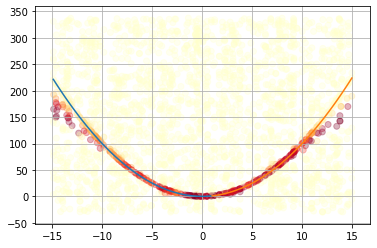

In [26]:
Plot('test2').picture(TestData.x, discriminator.model.predict(TestData.x))

In [27]:
NewData = Dataset()
NewData.load_data(data_range=11)

(array([[  9.56103437,  91.4133783 ],
        [  9.56103437,  76.6113876 ],
        [  9.56103437,  86.53722758],
        ...,
        [ -7.70239825,  54.79448628],
        [ -7.70239825, -11.1464109 ],
        [ -7.70239825,  62.90336199]]), array([1, 0, 0, ..., 0, 0, 0]))

In [30]:
gan = define_gan(generator.model, discriminator.model)

In [31]:
fit_gan(gan, NewData, 3000)

Epoch 0
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 3ms/sample - loss: 34.1979
Epoch 2/2
64/64 [==============================] - 0s 247us/sample - loss: 32.0659
Fitting discriminator
64/64 [==============================] - 0s 562us/sample - loss: 0.6754 - acc: 0.6250
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 282us/sample - loss: 0.1138 - acc: 0.9588 - val_loss: 0.1506 - val_acc: 0.9432
Epoch 1
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 264us/sample - loss: 22.5288
Epoch 2/2
64/64 [==============================] - 0s 366us/sample - loss: 21.0780
Fitting discriminator
64/64 [==============================] - 0s 261us/sample - loss: 0.7808 - acc: 0.6250
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 250us/sample - loss: 0.1075 - acc: 0.9567 - val_loss: 0.1365 - val_acc: 0.9489
Epoch 2
Fitting GAN
Epoch 1/2
64/64 [=============================

Epoch 35
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 248us/sample - loss: 1.4794
Epoch 2/2
64/64 [==============================] - 0s 245us/sample - loss: 1.4670
Fitting discriminator
64/64 [==============================] - 0s 269us/sample - loss: 0.5865 - acc: 0.5469
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 226us/sample - loss: 0.1003 - acc: 0.9595 - val_loss: 0.1195 - val_acc: 0.9545
Epoch 36
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 246us/sample - loss: 1.7270
Epoch 2/2
64/64 [==============================] - 0s 310us/sample - loss: 1.7144
Fitting discriminator
64/64 [==============================] - 0s 280us/sample - loss: 0.5158 - acc: 0.6875
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 251us/sample - loss: 0.1009 - acc: 0.9588 - val_loss: 0.1245 - val_acc: 0.9574
Epoch 37
Fitting GAN
Epoch 1/2
64/64 [============================

1408/1408 [==============================] - 0s 298us/sample - loss: 0.1000 - acc: 0.9609 - val_loss: 0.1288 - val_acc: 0.9261
Epoch 70
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 283us/sample - loss: 2.0807
Epoch 2/2
64/64 [==============================] - 0s 353us/sample - loss: 2.0750
Fitting discriminator
64/64 [==============================] - 0s 358us/sample - loss: 0.2982 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 256us/sample - loss: 0.1068 - acc: 0.9517 - val_loss: 0.1375 - val_acc: 0.9460
Epoch 71
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 335us/sample - loss: 1.5129
Epoch 2/2
64/64 [==============================] - 0s 268us/sample - loss: 1.4979
Fitting discriminator
64/64 [==============================] - 0s 305us/sample - loss: 0.3909 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 292us/sample - los

64/64 [==============================] - 0s 592us/sample - loss: 0.2937 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 214us/sample - loss: 0.1021 - acc: 0.9560 - val_loss: 0.1188 - val_acc: 0.9574
Epoch 105
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.8521
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.8498
Fitting discriminator
64/64 [==============================] - 0s 467us/sample - loss: 0.2748 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 193us/sample - loss: 0.1029 - acc: 0.9560 - val_loss: 0.1154 - val_acc: 0.9545
Epoch 106
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.8752
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.8721
Fitting discriminator
64/64 [==============================] - 0s 374us/sample - loss:

64/64 [==============================] - 0s 483us/sample - loss: 1.6069
Fitting discriminator
64/64 [==============================] - 0s 358us/sample - loss: 0.2747 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 203us/sample - loss: 0.1136 - acc: 0.9510 - val_loss: 0.1347 - val_acc: 0.9261
Epoch 140
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 282us/sample - loss: 1.8848
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.8811
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.2180 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 203us/sample - loss: 0.1184 - acc: 0.9595 - val_loss: 0.1406 - val_acc: 0.9403
Epoch 141
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 265us/sample - loss: 1.7879
Epoch 2/2
64/64 [==============================] - 0s 312us/sample - loss:

64/64 [==============================] - 0s 203us/sample - loss: 1.9922
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.9895
Fitting discriminator
64/64 [==============================] - 0s 203us/sample - loss: 0.1946 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 197us/sample - loss: 0.1018 - acc: 0.9624 - val_loss: 0.1136 - val_acc: 0.9545
Epoch 175
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 343us/sample - loss: 1.9601
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.9574
Fitting discriminator
64/64 [==============================] - 0s 405us/sample - loss: 0.1960 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 198us/sample - loss: 0.1066 - acc: 0.9553 - val_loss: 0.1240 - val_acc: 0.9375
Epoch 176
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 296us/sample - loss:

Epoch 209
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.8256
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.8244
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.1979 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 176us/sample - loss: 0.1066 - acc: 0.9574 - val_loss: 0.1080 - val_acc: 0.9517
Epoch 210
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.9292
Epoch 2/2
64/64 [==============================] - 0s 312us/sample - loss: 1.9265
Fitting discriminator
64/64 [==============================] - 0s 250us/sample - loss: 0.1934 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 173us/sample - loss: 0.1020 - acc: 0.9581 - val_loss: 0.1311 - val_acc: 0.9517
Epoch 211
Fitting GAN
Epoch 1/2
64/64 [=========================

Epoch 244
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.8605
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.8571
Fitting discriminator
64/64 [==============================] - 0s 171us/sample - loss: 0.1956 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 164us/sample - loss: 0.1085 - acc: 0.9524 - val_loss: 0.1177 - val_acc: 0.9432
Epoch 245
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.7621
Epoch 2/2
64/64 [==============================] - 0s 343us/sample - loss: 1.7569
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.2138 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 187us/sample - loss: 0.1124 - acc: 0.9489 - val_loss: 0.1091 - val_acc: 0.9517
Epoch 246
Fitting GAN
Epoch 1/2
64/64 [=========================

1408/1408 [==============================] - 0s 189us/sample - loss: 0.1203 - acc: 0.9474 - val_loss: 0.1322 - val_acc: 0.9432
Epoch 279
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.8291
Epoch 2/2
64/64 [==============================] - 0s 374us/sample - loss: 1.8245
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0.1951 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 187us/sample - loss: 0.1044 - acc: 0.9538 - val_loss: 0.1255 - val_acc: 0.9205
Epoch 280
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.7650
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.7637
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.2000 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 175us/sample - l

64/64 [==============================] - 0s 187us/sample - loss: 1.8429
Fitting discriminator
64/64 [==============================] - 0s 250us/sample - loss: 0.1817 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 169us/sample - loss: 0.1089 - acc: 0.9524 - val_loss: 0.1215 - val_acc: 0.9318
Epoch 297
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 327us/sample - loss: 1.8667
Epoch 2/2
64/64 [==============================] - 0s 390us/sample - loss: 1.8635
Fitting discriminator
64/64 [==============================] - 0s 343us/sample - loss: 0.1944 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 169us/sample - loss: 0.1189 - acc: 0.9510 - val_loss: 0.1522 - val_acc: 0.9347
Epoch 298
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.8966
Epoch 2/2
64/64 [==============================] - 0s 390us/sample - loss:

1408/1408 [==============================] - 0s 176us/sample - loss: 0.1013 - acc: 0.9588 - val_loss: 0.1237 - val_acc: 0.9545
Epoch 314
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.7875
Epoch 2/2
64/64 [==============================] - 0s 390us/sample - loss: 1.7844
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.1955 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 188us/sample - loss: 0.1046 - acc: 0.9553 - val_loss: 0.1220 - val_acc: 0.9517
Epoch 315
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.7570
Epoch 2/2
64/64 [==============================] - 0s 312us/sample - loss: 1.7551
Fitting discriminator
64/64 [==============================] - 0s 327us/sample - loss: 0.2016 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 181us/sample - l

64/64 [==============================] - 0s 265us/sample - loss: 0.2011 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 178us/sample - loss: 0.1438 - acc: 0.9290 - val_loss: 0.1827 - val_acc: 0.9375
Epoch 349
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.6513
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.6494
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.2183 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 196us/sample - loss: 0.1429 - acc: 0.9368 - val_loss: 0.1663 - val_acc: 0.9119
Epoch 350
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 373us/sample - loss: 1.6819
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.6805
Fitting discriminator
64/64 [==============================] - 0s 327us/sample - loss:

Epoch 366
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.6789
Epoch 2/2
64/64 [==============================] - 0s 281us/sample - loss: 1.6743
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.2146 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 170us/sample - loss: 0.1446 - acc: 0.9389 - val_loss: 0.1691 - val_acc: 0.9205
Epoch 367
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.6472
Epoch 2/2
64/64 [==============================] - 0s 328us/sample - loss: 1.6483
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.2189 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 174us/sample - loss: 0.1399 - acc: 0.9396 - val_loss: 0.1655 - val_acc: 0.9034
Epoch 368
Fitting GAN
Epoch 1/2
64/64 [=========================

Epoch 401
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.6291
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.6267
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.2221 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 176us/sample - loss: 0.1068 - acc: 0.9595 - val_loss: 0.1148 - val_acc: 0.9460
Epoch 402
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.6471
Epoch 2/2
64/64 [==============================] - 0s 327us/sample - loss: 1.6471
Fitting discriminator
64/64 [==============================] - 0s 358us/sample - loss: 0.2172 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 208us/sample - loss: 0.1368 - acc: 0.9396 - val_loss: 0.1535 - val_acc: 0.9176
Epoch 403
Fitting GAN
Epoch 1/2
64/64 [=========================

Epoch 436
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.6876
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.6823
Fitting discriminator
64/64 [==============================] - 0s 234us/sample - loss: 0.2090 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 201us/sample - loss: 0.1126 - acc: 0.9531 - val_loss: 0.1218 - val_acc: 0.9489
Epoch 437
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 358us/sample - loss: 1.7416
Epoch 2/2
64/64 [==============================] - 0s 327us/sample - loss: 1.7418
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss: 0.1954 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 199us/sample - loss: 0.1103 - acc: 0.9517 - val_loss: 0.1253 - val_acc: 0.9432
Epoch 438
Fitting GAN
Epoch 1/2
64/64 [=========================

1408/1408 [==============================] - 0s 183us/sample - loss: 0.1077 - acc: 0.9545 - val_loss: 0.1084 - val_acc: 0.9545
Epoch 471
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.7819
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.7808
Fitting discriminator
64/64 [==============================] - 0s 280us/sample - loss: 0.1871 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 197us/sample - loss: 0.1016 - acc: 0.9574 - val_loss: 0.1354 - val_acc: 0.9460
Epoch 472
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 732us/sample - loss: 1.7253
Epoch 2/2
64/64 [==============================] - 0s 280us/sample - loss: 1.7244
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss: 0.1975 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 273us/sample - l

64/64 [==============================] - 0s 203us/sample - loss: 0.1912 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 188us/sample - loss: 0.1028 - acc: 0.9609 - val_loss: 0.1225 - val_acc: 0.9403
Epoch 506
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.7276
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.7264
Fitting discriminator
64/64 [==============================] - 0s 327us/sample - loss: 0.1963 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 174us/sample - loss: 0.1302 - acc: 0.9411 - val_loss: 0.1506 - val_acc: 0.9176
Epoch 507
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.7876
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.7860
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss:

Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.7722
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 1.7665
Fitting discriminator
64/64 [==============================] - 0s 327us/sample - loss: 0.1892 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 169us/sample - loss: 0.1067 - acc: 0.9567 - val_loss: 0.1202 - val_acc: 0.9545
Epoch 541
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.7453
Epoch 2/2
64/64 [==============================] - 0s 312us/sample - loss: 1.7355
Fitting discriminator
64/64 [==============================] - 0s 280us/sample - loss: 0.1939 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 172us/sample - loss: 0.1055 - acc: 0.9581 - val_loss: 0.1225 - val_acc: 0.9403
Epoch 542
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0

1408/1408 [==============================] - 0s 204us/sample - loss: 0.1250 - acc: 0.9489 - val_loss: 0.1161 - val_acc: 0.9517
Epoch 575
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.7655
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.7610
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.1896 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 188us/sample - loss: 0.0990 - acc: 0.9602 - val_loss: 0.1138 - val_acc: 0.9460
Epoch 576
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.7446
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.7441
Fitting discriminator
64/64 [==============================] - 0s 327us/sample - loss: 0.1956 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 199us/sample - l

64/64 [==============================] - 0s 187us/sample - loss: 1.7096
Fitting discriminator
64/64 [==============================] - 0s 187us/sample - loss: 0.2020 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 201us/sample - loss: 0.1016 - acc: 0.9595 - val_loss: 0.1130 - val_acc: 0.9517
Epoch 593
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 312us/sample - loss: 1.7736
Epoch 2/2
64/64 [==============================] - 0s 359us/sample - loss: 1.7708
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0.1885 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 181us/sample - loss: 0.1059 - acc: 0.9553 - val_loss: 0.1246 - val_acc: 0.9261
Epoch 594
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.7574
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss:

64/64 [==============================] - 0s 171us/sample - loss: 1.7903
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.1831 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 183us/sample - loss: 0.1010 - acc: 0.9616 - val_loss: 0.1209 - val_acc: 0.9517
Epoch 628
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.7160
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.7065
Fitting discriminator
64/64 [==============================] - 0s 280us/sample - loss: 0.1997 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 167us/sample - loss: 0.1077 - acc: 0.9567 - val_loss: 0.1180 - val_acc: 0.9489
Epoch 629
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.7956
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss:

64/64 [==============================] - 0s 203us/sample - loss: 1.7501
Fitting discriminator
64/64 [==============================] - 0s 343us/sample - loss: 0.1925 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 206us/sample - loss: 0.1261 - acc: 0.9446 - val_loss: 0.1812 - val_acc: 0.9347
Epoch 663
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.7124
Epoch 2/2
64/64 [==============================] - 0s 343us/sample - loss: 1.7088
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss: 0.2015 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 183us/sample - loss: 0.1301 - acc: 0.9453 - val_loss: 0.1142 - val_acc: 0.9545
Epoch 664
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.8007
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss:

64/64 [==============================] - 0s 187us/sample - loss: 1.7889
Fitting discriminator
64/64 [==============================] - 0s 171us/sample - loss: 0.1866 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 176us/sample - loss: 0.1343 - acc: 0.9403 - val_loss: 0.1451 - val_acc: 0.9489
Epoch 698
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 202us/sample - loss: 1.7801
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.7720
Fitting discriminator
64/64 [==============================] - 0s 218us/sample - loss: 0.1901 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 167us/sample - loss: 0.1172 - acc: 0.9517 - val_loss: 0.1747 - val_acc: 0.9375
Epoch 699
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.7946
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss:

64/64 [==============================] - 0s 171us/sample - loss: 1.8013
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.1838 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 242us/sample - loss: 0.1077 - acc: 0.9567 - val_loss: 0.1286 - val_acc: 0.9432
Epoch 733
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 296us/sample - loss: 1.7778
Epoch 2/2
64/64 [==============================] - 0s 561us/sample - loss: 1.7773
Fitting discriminator
64/64 [==============================] - 0s 452us/sample - loss: 0.1888 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 185us/sample - loss: 0.1152 - acc: 0.9538 - val_loss: 0.1528 - val_acc: 0.9460
Epoch 734
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.7873
Epoch 2/2
64/64 [==============================] - 0s 327us/sample - loss:

64/64 [==============================] - 0s 156us/sample - loss: 1.8205
Fitting discriminator
64/64 [==============================] - 0s 218us/sample - loss: 0.1803 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 191us/sample - loss: 0.0987 - acc: 0.9581 - val_loss: 0.1109 - val_acc: 0.9517
Epoch 768
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.8547
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.8529
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.1759 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 186us/sample - loss: 0.0981 - acc: 0.9560 - val_loss: 0.1106 - val_acc: 0.9545
Epoch 769
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.7849
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss:

64/64 [==============================] - 0s 171us/sample - loss: 1.8987
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.8856
Fitting discriminator
64/64 [==============================] - 0s 171us/sample - loss: 0.1650 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 242us/sample - loss: 0.1161 - acc: 0.9474 - val_loss: 0.1262 - val_acc: 0.9460
Epoch 803
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 296us/sample - loss: 1.8768
Epoch 2/2
64/64 [==============================] - 0s 452us/sample - loss: 1.8764
Fitting discriminator
64/64 [==============================] - 0s 218us/sample - loss: 0.1697 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 203us/sample - loss: 0.1091 - acc: 0.9567 - val_loss: 0.1153 - val_acc: 0.9631
Epoch 804
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss:

Epoch 837
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.8682
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.8680
Fitting discriminator
64/64 [==============================] - 0s 343us/sample - loss: 0.1721 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 164us/sample - loss: 0.1089 - acc: 0.9567 - val_loss: 0.1252 - val_acc: 0.9432
Epoch 838
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.8746
Epoch 2/2
64/64 [==============================] - 0s 281us/sample - loss: 1.8699
Fitting discriminator
64/64 [==============================] - 0s 405us/sample - loss: 0.1801 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 194us/sample - loss: 0.1148 - acc: 0.9545 - val_loss: 0.1444 - val_acc: 0.9261
Epoch 839
Fitting GAN
Epoch 1/2
64/64 [=========================

Epoch 872
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.8291
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.8270
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.1864 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 177us/sample - loss: 0.1008 - acc: 0.9616 - val_loss: 0.1302 - val_acc: 0.9545
Epoch 873
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 265us/sample - loss: 1.8495
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.8481
Fitting discriminator
64/64 [==============================] - 0s 343us/sample - loss: 0.1772 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 198us/sample - loss: 0.1059 - acc: 0.9560 - val_loss: 0.1196 - val_acc: 0.9375
Epoch 874
Fitting GAN
Epoch 1/2
64/64 [=========================

Epoch 907
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.9437
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.9466
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.1739 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 183us/sample - loss: 0.1033 - acc: 0.9567 - val_loss: 0.2120 - val_acc: 0.9290
Epoch 908
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.9613
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 1.9531
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.1570 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 184us/sample - loss: 0.1166 - acc: 0.9574 - val_loss: 0.1247 - val_acc: 0.9574
Epoch 909
Fitting GAN
Epoch 1/2
64/64 [=========================

Epoch 942
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 2.1392
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 2.1006
Fitting discriminator
64/64 [==============================] - 0s 203us/sample - loss: 0.1884 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 206us/sample - loss: 0.0984 - acc: 0.9602 - val_loss: 0.1429 - val_acc: 0.9375
Epoch 943
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.9491
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.9227
Fitting discriminator
64/64 [==============================] - 0s 390us/sample - loss: 0.2505 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 169us/sample - loss: 0.1192 - acc: 0.9482 - val_loss: 0.1223 - val_acc: 0.9375
Epoch 944
Fitting GAN
Epoch 1/2
64/64 [=========================

Epoch 977
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.9141
Epoch 2/2
64/64 [==============================] - 0s 218us/sample - loss: 1.9000
Fitting discriminator
64/64 [==============================] - 0s 203us/sample - loss: 0.1994 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 194us/sample - loss: 0.0947 - acc: 0.9631 - val_loss: 0.1045 - val_acc: 0.9489
Epoch 978
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 265us/sample - loss: 2.0398
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.8232
Fitting discriminator
64/64 [==============================] - 0s 389us/sample - loss: 0.2162 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 228us/sample - loss: 0.0981 - acc: 0.9609 - val_loss: 0.1300 - val_acc: 0.9290
Epoch 979
Fitting GAN
Epoch 1/2
64/64 [=========================

Epoch 1012
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.8219
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.8118
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.2436 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 183us/sample - loss: 0.0969 - acc: 0.9616 - val_loss: 0.1286 - val_acc: 0.9261
Epoch 1013
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 265us/sample - loss: 1.9115
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.8994
Fitting discriminator
64/64 [==============================] - 0s 421us/sample - loss: 0.2138 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 167us/sample - loss: 0.1096 - acc: 0.9524 - val_loss: 0.1138 - val_acc: 0.9347
Epoch 1014
Fitting GAN
Epoch 1/2
64/64 [======================

1408/1408 [==============================] - 0s 194us/sample - loss: 0.1015 - acc: 0.9574 - val_loss: 0.1220 - val_acc: 0.9347
Epoch 1047
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.8968
Epoch 2/2
64/64 [==============================] - 0s 390us/sample - loss: 1.8901
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.1885 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 164us/sample - loss: 0.1010 - acc: 0.9574 - val_loss: 0.1300 - val_acc: 0.9517
Epoch 1048
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.8846
Epoch 2/2
64/64 [==============================] - 0s 312us/sample - loss: 1.8802
Fitting discriminator
64/64 [==============================] - 0s 358us/sample - loss: 0.1800 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 163us/sample -

64/64 [==============================] - 0s 218us/sample - loss: 0.1818 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 177us/sample - loss: 0.0982 - acc: 0.9567 - val_loss: 0.1125 - val_acc: 0.9545
Epoch 1082
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.9691
Epoch 2/2
64/64 [==============================] - 0s 374us/sample - loss: 1.9601
Fitting discriminator
64/64 [==============================] - 0s 218us/sample - loss: 0.1740 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 160us/sample - loss: 0.0928 - acc: 0.9652 - val_loss: 0.1461 - val_acc: 0.9375
Epoch 1083
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 405us/sample - loss: 1.8330
Epoch 2/2
64/64 [==============================] - 0s 499us/sample - loss: 1.8284
Fitting discriminator
64/64 [==============================] - 0s 389us/sample - los

Epoch 1099
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.8461
Epoch 2/2
64/64 [==============================] - 0s 218us/sample - loss: 1.8486
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0.2591 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 181us/sample - loss: 0.1051 - acc: 0.9574 - val_loss: 0.1488 - val_acc: 0.9432
Epoch 1100
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 378us/sample - loss: 2.1443
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 2.0681
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0.2108 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 171us/sample - loss: 0.1096 - acc: 0.9517 - val_loss: 0.1753 - val_acc: 0.9034
Epoch 1101
Fitting GAN
Epoch 1/2
64/64 [======================

64/64 [==============================] - 0s 249us/sample - loss: 0.2259 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 248us/sample - loss: 0.1025 - acc: 0.9567 - val_loss: 0.1248 - val_acc: 0.9261
Epoch 1117
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 312us/sample - loss: 1.7309
Epoch 2/2
64/64 [==============================] - 0s 312us/sample - loss: 1.7012
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.2619 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 207us/sample - loss: 0.0971 - acc: 0.9616 - val_loss: 0.1111 - val_acc: 0.9489
Epoch 1118
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.8569
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.8509
Fitting discriminator
64/64 [==============================] - 0s 530us/sample - los

Epoch 1134
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.8086
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 1.8011
Fitting discriminator
64/64 [==============================] - 0s 343us/sample - loss: 0.2529 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 180us/sample - loss: 0.1077 - acc: 0.9482 - val_loss: 0.1670 - val_acc: 0.9347
Epoch 1135
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.7760
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.7680
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.2704 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 186us/sample - loss: 0.1020 - acc: 0.9595 - val_loss: 0.1217 - val_acc: 0.9261
Epoch 1136
Fitting GAN
Epoch 1/2
64/64 [======================

1408/1408 [==============================] - 0s 191us/sample - loss: 0.0939 - acc: 0.9602 - val_loss: 0.1095 - val_acc: 0.9545
Epoch 1169
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.7256
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.7178
Fitting discriminator
64/64 [==============================] - 0s 280us/sample - loss: 0.2992 - acc: 0.9062
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 169us/sample - loss: 0.0982 - acc: 0.9616 - val_loss: 0.1112 - val_acc: 0.9489
Epoch 1170
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 375us/sample - loss: 1.8198
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.8148
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.2166 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 163us/sample -

64/64 [==============================] - 0s 296us/sample - loss: 0.2128 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 182us/sample - loss: 0.0998 - acc: 0.9602 - val_loss: 0.1494 - val_acc: 0.9119
Epoch 1204
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.8307
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.8143
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.2455 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 180us/sample - loss: 0.1133 - acc: 0.9489 - val_loss: 0.1158 - val_acc: 0.9432
Epoch 1205
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.7640
Epoch 2/2
64/64 [==============================] - 0s 281us/sample - loss: 1.7173
Fitting discriminator
64/64 [==============================] - 0s 311us/sample - los

64/64 [==============================] - 0s 172us/sample - loss: 1.7611
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 1.7508
Fitting discriminator
64/64 [==============================] - 0s 187us/sample - loss: 0.2665 - acc: 0.9062
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 180us/sample - loss: 0.1181 - acc: 0.9503 - val_loss: 0.1376 - val_acc: 0.9347
Epoch 1239
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.8454
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.8334
Fitting discriminator
64/64 [==============================] - 0s 218us/sample - loss: 0.2465 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 163us/sample - loss: 0.1076 - acc: 0.9553 - val_loss: 0.1147 - val_acc: 0.9517
Epoch 1240
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 320us/sample - los

Epoch 1273
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 281us/sample - loss: 1.6006
Epoch 2/2
64/64 [==============================] - 0s 218us/sample - loss: 1.5867
Fitting discriminator
64/64 [==============================] - 0s 234us/sample - loss: 0.3053 - acc: 0.8906
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 218us/sample - loss: 0.1047 - acc: 0.9560 - val_loss: 0.1152 - val_acc: 0.9517
Epoch 1274
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 296us/sample - loss: 1.7456
Epoch 2/2
64/64 [==============================] - 0s 514us/sample - loss: 1.7219
Fitting discriminator
64/64 [==============================] - 0s 421us/sample - loss: 0.2561 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 239us/sample - loss: 0.1004 - acc: 0.9616 - val_loss: 0.1192 - val_acc: 0.9432
Epoch 1275
Fitting GAN
Epoch 1/2
64/64 [======================

1408/1408 [==============================] - 0s 164us/sample - loss: 0.0977 - acc: 0.9574 - val_loss: 0.1149 - val_acc: 0.9545
Epoch 1308
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.6172
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.5950
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.3731 - acc: 0.8750
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 168us/sample - loss: 0.0980 - acc: 0.9616 - val_loss: 0.1789 - val_acc: 0.9318
Epoch 1309
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.6207
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.6132
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0.3392 - acc: 0.8594
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 180us/sample -

64/64 [==============================] - 0s 187us/sample - loss: 0.3740 - acc: 0.8906
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 187us/sample - loss: 0.1091 - acc: 0.9503 - val_loss: 0.1098 - val_acc: 0.9517
Epoch 1343
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.7017
Epoch 2/2
64/64 [==============================] - 0s 436us/sample - loss: 1.6742
Fitting discriminator
64/64 [==============================] - 0s 390us/sample - loss: 0.3556 - acc: 0.8750
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 201us/sample - loss: 0.0973 - acc: 0.9588 - val_loss: 0.1086 - val_acc: 0.9517
Epoch 1344
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.5971
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.5871
Fitting discriminator
64/64 [==============================] - 0s 218us/sample - los

Epoch 1360
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.6633
Epoch 2/2
64/64 [==============================] - 0s 250us/sample - loss: 1.5740
Fitting discriminator
64/64 [==============================] - 0s 436us/sample - loss: 0.3498 - acc: 0.8750
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 201us/sample - loss: 0.1141 - acc: 0.9460 - val_loss: 0.1150 - val_acc: 0.9517
Epoch 1361
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.6681
Epoch 2/2
64/64 [==============================] - 0s 327us/sample - loss: 1.6755
Fitting discriminator
64/64 [==============================] - 0s 280us/sample - loss: 0.3317 - acc: 0.9062
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 164us/sample - loss: 0.1010 - acc: 0.9609 - val_loss: 0.1178 - val_acc: 0.9545
Epoch 1362
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 1395
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.4591
Epoch 2/2
64/64 [==============================] - 0s 218us/sample - loss: 1.4474
Fitting discriminator
64/64 [==============================] - 0s 203us/sample - loss: 0.3901 - acc: 0.8594
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 178us/sample - loss: 0.1015 - acc: 0.9553 - val_loss: 0.1226 - val_acc: 0.9176
Epoch 1396
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.7815
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.6272
Fitting discriminator
64/64 [==============================] - 0s 404us/sample - loss: 0.3487 - acc: 0.8594
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 165us/sample - loss: 0.0987 - acc: 0.9553 - val_loss: 0.1114 - val_acc: 0.9233
Epoch 1397
Fitting GAN
Epoch 1/2
64/64 [======================

Fitting discriminator
64/64 [==============================] - 0s 187us/sample - loss: 0.4045 - acc: 0.8281
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 171us/sample - loss: 0.1202 - acc: 0.9489 - val_loss: 0.1232 - val_acc: 0.9375
Epoch 1413
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.4547
Epoch 2/2
64/64 [==============================] - 0s 312us/sample - loss: 1.4454
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.3295 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 208us/sample - loss: 0.1114 - acc: 0.9460 - val_loss: 0.1110 - val_acc: 0.9489
Epoch 1414
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.4976
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.4940
Fitting discriminator
64/64 [==============================] -

64/64 [==============================] - 0s 156us/sample - loss: 1.3757
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.3694
Fitting discriminator
64/64 [==============================] - 0s 171us/sample - loss: 0.3951 - acc: 0.8594
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 188us/sample - loss: 0.1080 - acc: 0.9531 - val_loss: 0.1224 - val_acc: 0.9403
Epoch 1448
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.4425
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.4334
Fitting discriminator
64/64 [==============================] - 0s 234us/sample - loss: 0.4116 - acc: 0.8750
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 193us/sample - loss: 0.1257 - acc: 0.9403 - val_loss: 0.1963 - val_acc: 0.9176
Epoch 1449
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - los

1408/1408 [==============================] - 0s 185us/sample - loss: 0.1049 - acc: 0.9510 - val_loss: 0.1186 - val_acc: 0.9403
Epoch 1482
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 280us/sample - loss: 1.4724
Epoch 2/2
64/64 [==============================] - 0s 281us/sample - loss: 1.4659
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss: 0.3691 - acc: 0.8594
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 169us/sample - loss: 0.0969 - acc: 0.9581 - val_loss: 0.1093 - val_acc: 0.9375
Epoch 1483
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 312us/sample - loss: 1.3934
Epoch 2/2
64/64 [==============================] - 0s 343us/sample - loss: 1.3885
Fitting discriminator
64/64 [==============================] - 0s 405us/sample - loss: 0.3523 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 191us/sample -

64/64 [==============================] - 0s 234us/sample - loss: 0.4023 - acc: 0.8750
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 204us/sample - loss: 0.1121 - acc: 0.9474 - val_loss: 0.1564 - val_acc: 0.9403
Epoch 1517
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 312us/sample - loss: 1.4527
Epoch 2/2
64/64 [==============================] - 0s 468us/sample - loss: 1.3397
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.5381 - acc: 0.7812
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 200us/sample - loss: 0.1103 - acc: 0.9503 - val_loss: 0.1178 - val_acc: 0.9233
Epoch 1518
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 281us/sample - loss: 1.3887
Epoch 2/2
64/64 [==============================] - 0s 327us/sample - loss: 1.3967
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - los

Epoch 1534
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.3516
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.3205
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.3889 - acc: 0.8906
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 191us/sample - loss: 0.1148 - acc: 0.9467 - val_loss: 0.1197 - val_acc: 0.9375
Epoch 1535
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.2894
Epoch 2/2
64/64 [==============================] - 0s 218us/sample - loss: 1.2951
Fitting discriminator
64/64 [==============================] - 0s 390us/sample - loss: 0.4836 - acc: 0.8281
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 171us/sample - loss: 0.1052 - acc: 0.9489 - val_loss: 0.1164 - val_acc: 0.9432
Epoch 1536
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 1569
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.2326
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.2314
Fitting discriminator
64/64 [==============================] - 0s 187us/sample - loss: 0.5046 - acc: 0.7188
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 194us/sample - loss: 0.1062 - acc: 0.9453 - val_loss: 0.1155 - val_acc: 0.9261
Epoch 1570
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 148us/sample - loss: 1.2648
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.2571
Fitting discriminator
64/64 [==============================] - 0s 218us/sample - loss: 0.4375 - acc: 0.7969
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 165us/sample - loss: 0.1010 - acc: 0.9482 - val_loss: 0.1131 - val_acc: 0.9403
Epoch 1571
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 1604
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.3250
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.3194
Fitting discriminator
64/64 [==============================] - 0s 156us/sample - loss: 0.4170 - acc: 0.8438
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 160us/sample - loss: 0.1156 - acc: 0.9467 - val_loss: 0.1472 - val_acc: 0.9176
Epoch 1605
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.3159
Epoch 2/2
64/64 [==============================] - 0s 265us/sample - loss: 1.2992
Fitting discriminator
64/64 [==============================] - 0s 280us/sample - loss: 0.4406 - acc: 0.8125
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 160us/sample - loss: 0.1494 - acc: 0.9283 - val_loss: 0.1821 - val_acc: 0.8949
Epoch 1606
Fitting GAN
Epoch 1/2
64/64 [======================

64/64 [==============================] - 0s 203us/sample - loss: 0.3817 - acc: 0.8750
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 192us/sample - loss: 0.1119 - acc: 0.9425 - val_loss: 0.1323 - val_acc: 0.9375
Epoch 1622
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.2083
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.2019
Fitting discriminator
64/64 [==============================] - 0s 171us/sample - loss: 0.4571 - acc: 0.7969
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 205us/sample - loss: 0.1161 - acc: 0.9439 - val_loss: 0.1182 - val_acc: 0.9375
Epoch 1623
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 281us/sample - loss: 1.2635
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.2590
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - los

Epoch 1639
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.2016
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.1956
Fitting discriminator
64/64 [==============================] - 0s 234us/sample - loss: 0.4616 - acc: 0.8281
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 169us/sample - loss: 0.1133 - acc: 0.9361 - val_loss: 0.1141 - val_acc: 0.9432
Epoch 1640
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.2974
Epoch 2/2
64/64 [==============================] - 0s 140us/sample - loss: 1.2918
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.4409 - acc: 0.8125
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 147us/sample - loss: 0.1058 - acc: 0.9411 - val_loss: 0.1168 - val_acc: 0.9432
Epoch 1641
Fitting GAN
Epoch 1/2
64/64 [======================

1408/1408 [==============================] - 0s 172us/sample - loss: 0.1092 - acc: 0.9418 - val_loss: 0.1116 - val_acc: 0.9261
Epoch 1674
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 171us/sample - loss: 1.2695
Epoch 2/2
64/64 [==============================] - 0s 312us/sample - loss: 1.2512
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.4031 - acc: 0.8750
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 167us/sample - loss: 0.1010 - acc: 0.9489 - val_loss: 0.1191 - val_acc: 0.9432
Epoch 1675
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.3502
Epoch 2/2
64/64 [==============================] - 0s 280us/sample - loss: 1.3373
Fitting discriminator
64/64 [==============================] - 0s 343us/sample - loss: 0.3595 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 170us/sample -

64/64 [==============================] - 0s 156us/sample - loss: 0.3958 - acc: 0.8750
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 137us/sample - loss: 0.1027 - acc: 0.9453 - val_loss: 0.1199 - val_acc: 0.9403
Epoch 1709
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.1632
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.1588
Fitting discriminator
64/64 [==============================] - 0s 202us/sample - loss: 0.4628 - acc: 0.8125
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 171us/sample - loss: 0.1136 - acc: 0.9403 - val_loss: 0.1203 - val_acc: 0.9205
Epoch 1710
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.2482
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 1.2477
Fitting discriminator
64/64 [==============================] - 0s 327us/sample - los

64/64 [==============================] - 0s 218us/sample - loss: 1.2650
Epoch 2/2
64/64 [==============================] - 0s 234us/sample - loss: 1.2581
Fitting discriminator
64/64 [==============================] - 0s 234us/sample - loss: 0.4025 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 210us/sample - loss: 0.1082 - acc: 0.9446 - val_loss: 0.1156 - val_acc: 0.9403
Epoch 1744
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.2208
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.2117
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss: 0.4020 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 159us/sample - loss: 0.1063 - acc: 0.9453 - val_loss: 0.1237 - val_acc: 0.9460
Epoch 1745
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - los

Epoch 1778
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.3928
Epoch 2/2
64/64 [==============================] - 0s 203us/sample - loss: 1.3255
Fitting discriminator
64/64 [==============================] - 0s 203us/sample - loss: 0.3972 - acc: 0.8906
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 175us/sample - loss: 0.1118 - acc: 0.9411 - val_loss: 0.1239 - val_acc: 0.9205
Epoch 1779
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.2560
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.2146
Fitting discriminator
64/64 [==============================] - 0s 171us/sample - loss: 0.4256 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 191us/sample - loss: 0.1041 - acc: 0.9446 - val_loss: 0.1119 - val_acc: 0.9460
Epoch 1780
Fitting GAN
Epoch 1/2
64/64 [======================

64/64 [==============================] - 0s 156us/sample - loss: 0.4050 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 139us/sample - loss: 0.1199 - acc: 0.9382 - val_loss: 0.1199 - val_acc: 0.9375
Epoch 1796
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 156us/sample - loss: 1.2028
Epoch 2/2
64/64 [==============================] - 0s 156us/sample - loss: 1.1927
Fitting discriminator
64/64 [==============================] - 0s 156us/sample - loss: 0.4258 - acc: 0.8750
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 168us/sample - loss: 0.1117 - acc: 0.9418 - val_loss: 0.1294 - val_acc: 0.9205
Epoch 1797
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.3155
Epoch 2/2
64/64 [==============================] - 0s 171us/sample - loss: 1.3037
Fitting discriminator
64/64 [==============================] - 0s 343us/sample - los

Epoch 1813
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.1271
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.1237
Fitting discriminator
64/64 [==============================] - 0s 203us/sample - loss: 0.4650 - acc: 0.8906
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 203us/sample - loss: 0.1058 - acc: 0.9439 - val_loss: 0.1415 - val_acc: 0.9148
Epoch 1814
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 331us/sample - loss: 1.2897
Epoch 2/2
64/64 [==============================] - 0s 281us/sample - loss: 1.2850
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.3690 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 178us/sample - loss: 0.1242 - acc: 0.9325 - val_loss: 0.1188 - val_acc: 0.9403
Epoch 1815
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 1848
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.1795
Epoch 2/2
64/64 [==============================] - 0s 156us/sample - loss: 1.1849
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.3965 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 184us/sample - loss: 0.1152 - acc: 0.9389 - val_loss: 0.1082 - val_acc: 0.9489
Epoch 1849
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.2155
Epoch 2/2
64/64 [==============================] - 0s 249us/sample - loss: 1.2159
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.3886 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 167us/sample - loss: 0.0980 - acc: 0.9496 - val_loss: 0.1145 - val_acc: 0.9432
Epoch 1850
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 1883
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 140us/sample - loss: 1.2492
Epoch 2/2
64/64 [==============================] - 0s 156us/sample - loss: 1.2363
Fitting discriminator
64/64 [==============================] - 0s 187us/sample - loss: 0.3811 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 193us/sample - loss: 0.1190 - acc: 0.9368 - val_loss: 0.1252 - val_acc: 0.9375
Epoch 1884
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.2582
Epoch 2/2
64/64 [==============================] - 0s 280us/sample - loss: 1.2572
Fitting discriminator
64/64 [==============================] - 0s 203us/sample - loss: 0.3751 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 181us/sample - loss: 0.1239 - acc: 0.9403 - val_loss: 0.1632 - val_acc: 0.9347
Epoch 1885
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 1918
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.2176
Epoch 2/2
64/64 [==============================] - 0s 343us/sample - loss: 1.2001
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.4316 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 195us/sample - loss: 0.1097 - acc: 0.9453 - val_loss: 0.1194 - val_acc: 0.9432
Epoch 1919
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.2005
Epoch 2/2
64/64 [==============================] - 0s 343us/sample - loss: 1.1901
Fitting discriminator
64/64 [==============================] - 0s 358us/sample - loss: 0.4108 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 186us/sample - loss: 0.1153 - acc: 0.9418 - val_loss: 0.1414 - val_acc: 0.9347
Epoch 1920
Fitting GAN
Epoch 1/2
64/64 [======================

1408/1408 [==============================] - 0s 276us/sample - loss: 0.1072 - acc: 0.9403 - val_loss: 0.1185 - val_acc: 0.9148
Epoch 1953
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.2928
Epoch 2/2
64/64 [==============================] - 0s 218us/sample - loss: 1.2856
Fitting discriminator
64/64 [==============================] - 0s 249us/sample - loss: 0.3684 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 200us/sample - loss: 0.0999 - acc: 0.9496 - val_loss: 0.1089 - val_acc: 0.9460
Epoch 1954
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.1004
Epoch 2/2
64/64 [==============================] - 0s 327us/sample - loss: 1.0966
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - loss: 0.4471 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 197us/sample -

64/64 [==============================] - 0s 296us/sample - loss: 0.3662 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 205us/sample - loss: 0.0989 - acc: 0.9467 - val_loss: 0.1061 - val_acc: 0.9261
Epoch 1988
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 327us/sample - loss: 1.2461
Epoch 2/2
64/64 [==============================] - 0s 358us/sample - loss: 1.2377
Fitting discriminator
64/64 [==============================] - 0s 343us/sample - loss: 0.3710 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 205us/sample - loss: 0.1005 - acc: 0.9467 - val_loss: 0.1159 - val_acc: 0.9432
Epoch 1989
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 296us/sample - loss: 1.1960
Epoch 2/2
64/64 [==============================] - 0s 296us/sample - loss: 1.1851
Fitting discriminator
64/64 [==============================] - 0s 312us/sample - los

64/64 [==============================] - 0s 171us/sample - loss: 1.1359
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.1320
Fitting discriminator
64/64 [==============================] - 0s 156us/sample - loss: 0.4286 - acc: 0.9062
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 206us/sample - loss: 0.1274 - acc: 0.9304 - val_loss: 0.1129 - val_acc: 0.9489
Epoch 2023
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 249us/sample - loss: 1.2618
Epoch 2/2
64/64 [==============================] - 0s 280us/sample - loss: 1.2586
Fitting discriminator
64/64 [==============================] - 0s 483us/sample - loss: 0.3593 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 214us/sample - loss: 0.1234 - acc: 0.9361 - val_loss: 0.1131 - val_acc: 0.9290
Epoch 2024
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - los

Epoch 2057
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 218us/sample - loss: 1.0997
Epoch 2/2
64/64 [==============================] - 0s 187us/sample - loss: 1.0971
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.4703 - acc: 0.9062
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 187us/sample - loss: 0.1020 - acc: 0.9418 - val_loss: 0.1118 - val_acc: 0.9460
Epoch 2058
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 203us/sample - loss: 1.1809
Epoch 2/2
64/64 [==============================] - 0s 312us/sample - loss: 1.1825
Fitting discriminator
64/64 [==============================] - 0s 265us/sample - loss: 0.4009 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 190us/sample - loss: 0.0963 - acc: 0.9474 - val_loss: 0.1115 - val_acc: 0.9318
Epoch 2059
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2092
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.1315
Epoch 2/2
64/64 [==============================] - 0s 411us/sample - loss: 1.1343
Fitting discriminator
64/64 [==============================] - 0s 300us/sample - loss: 0.4227 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 264us/sample - loss: 0.1057 - acc: 0.9425 - val_loss: 0.1359 - val_acc: 0.9403
Epoch 2093
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 221us/sample - loss: 1.1708
Epoch 2/2
64/64 [==============================] - 0s 285us/sample - loss: 1.1623
Fitting discriminator
64/64 [==============================] - 0s 302us/sample - loss: 0.4253 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 235us/sample - loss: 0.1279 - acc: 0.9339 - val_loss: 0.1504 - val_acc: 0.9062
Epoch 2094
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2127
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 285us/sample - loss: 1.1931
Epoch 2/2
64/64 [==============================] - 0s 279us/sample - loss: 1.1721
Fitting discriminator
64/64 [==============================] - 0s 306us/sample - loss: 0.4071 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 259us/sample - loss: 0.1075 - acc: 0.9453 - val_loss: 0.1442 - val_acc: 0.9205
Epoch 2128
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 236us/sample - loss: 1.1809
Epoch 2/2
64/64 [==============================] - 0s 325us/sample - loss: 1.1808
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - loss: 0.3992 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 249us/sample - loss: 0.1022 - acc: 0.9453 - val_loss: 0.1309 - val_acc: 0.9375
Epoch 2129
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2162
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 365us/sample - loss: 1.2990
Epoch 2/2
64/64 [==============================] - 0s 422us/sample - loss: 1.2363
Fitting discriminator
64/64 [==============================] - 0s 452us/sample - loss: 0.3732 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 254us/sample - loss: 0.1061 - acc: 0.9418 - val_loss: 0.1263 - val_acc: 0.9375
Epoch 2163
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 240us/sample - loss: 1.1837
Epoch 2/2
64/64 [==============================] - 0s 337us/sample - loss: 1.1834
Fitting discriminator
64/64 [==============================] - 0s 371us/sample - loss: 0.4115 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 263us/sample - loss: 0.1086 - acc: 0.9432 - val_loss: 0.1164 - val_acc: 0.9403
Epoch 2164
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2197
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 222us/sample - loss: 1.2417
Epoch 2/2
64/64 [==============================] - 0s 252us/sample - loss: 1.2339
Fitting discriminator
64/64 [==============================] - 0s 361us/sample - loss: 0.3629 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 245us/sample - loss: 0.1102 - acc: 0.9382 - val_loss: 0.1155 - val_acc: 0.9403
Epoch 2198
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 501us/sample - loss: 1.1626
Epoch 2/2
64/64 [==============================] - 0s 348us/sample - loss: 1.1634
Fitting discriminator
64/64 [==============================] - 0s 298us/sample - loss: 0.4105 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 248us/sample - loss: 0.1061 - acc: 0.9396 - val_loss: 0.1653 - val_acc: 0.9290
Epoch 2199
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2232
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 376us/sample - loss: 1.2223
Epoch 2/2
64/64 [==============================] - 0s 245us/sample - loss: 1.1840
Fitting discriminator
64/64 [==============================] - 0s 298us/sample - loss: 0.4079 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 246us/sample - loss: 0.1008 - acc: 0.9467 - val_loss: 0.1065 - val_acc: 0.9347
Epoch 2233
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 221us/sample - loss: 1.2667
Epoch 2/2
64/64 [==============================] - 0s 256us/sample - loss: 1.2571
Fitting discriminator
64/64 [==============================] - 0s 299us/sample - loss: 0.3555 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 225us/sample - loss: 0.0979 - acc: 0.9474 - val_loss: 0.1055 - val_acc: 0.9403
Epoch 2234
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2267
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 271us/sample - loss: 1.2243
Epoch 2/2
64/64 [==============================] - 0s 323us/sample - loss: 1.2130
Fitting discriminator
64/64 [==============================] - 0s 240us/sample - loss: 0.3772 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 224us/sample - loss: 0.1145 - acc: 0.9389 - val_loss: 0.1160 - val_acc: 0.9460
Epoch 2268
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 256us/sample - loss: 1.2854
Epoch 2/2
64/64 [==============================] - 0s 288us/sample - loss: 1.2847
Fitting discriminator
64/64 [==============================] - 0s 319us/sample - loss: 0.3499 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 244us/sample - loss: 0.1031 - acc: 0.9482 - val_loss: 0.1118 - val_acc: 0.9460
Epoch 2269
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2302
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 261us/sample - loss: 1.2864
Epoch 2/2
64/64 [==============================] - 0s 257us/sample - loss: 1.2736
Fitting discriminator
64/64 [==============================] - 0s 502us/sample - loss: 0.3482 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 218us/sample - loss: 0.1282 - acc: 0.9332 - val_loss: 0.1117 - val_acc: 0.9233
Epoch 2303
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 292us/sample - loss: 1.0972
Epoch 2/2
64/64 [==============================] - 0s 380us/sample - loss: 1.0947
Fitting discriminator
64/64 [==============================] - 0s 278us/sample - loss: 0.4311 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 217us/sample - loss: 0.1039 - acc: 0.9432 - val_loss: 0.1211 - val_acc: 0.9403
Epoch 2304
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2337
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 188us/sample - loss: 1.1212
Epoch 2/2
64/64 [==============================] - 0s 261us/sample - loss: 1.1101
Fitting discriminator
64/64 [==============================] - 0s 421us/sample - loss: 0.4403 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 274us/sample - loss: 0.1067 - acc: 0.9439 - val_loss: 0.1112 - val_acc: 0.9290
Epoch 2338
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 307us/sample - loss: 1.2395
Epoch 2/2
64/64 [==============================] - 0s 355us/sample - loss: 1.2309
Fitting discriminator
64/64 [==============================] - 0s 351us/sample - loss: 0.3704 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 1s 402us/sample - loss: 0.1046 - acc: 0.9418 - val_loss: 0.1426 - val_acc: 0.9148
Epoch 2339
Fitting GAN
Epoch 1/2
64/64 [======================

64/64 [==============================] - 0s 340us/sample - loss: 0.4125 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 200us/sample - loss: 0.0982 - acc: 0.9474 - val_loss: 0.1108 - val_acc: 0.9403
Epoch 2355
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 241us/sample - loss: 1.1943
Epoch 2/2
64/64 [==============================] - 0s 269us/sample - loss: 1.1599
Fitting discriminator
64/64 [==============================] - 0s 267us/sample - loss: 0.4042 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 272us/sample - loss: 0.1094 - acc: 0.9432 - val_loss: 0.1709 - val_acc: 0.9176
Epoch 2356
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 345us/sample - loss: 1.1810
Epoch 2/2
64/64 [==============================] - 0s 231us/sample - loss: 1.1751
Fitting discriminator
64/64 [==============================] - 0s 445us/sample - los

64/64 [==============================] - 0s 217us/sample - loss: 1.1399
Epoch 2/2
64/64 [==============================] - 0s 409us/sample - loss: 1.1211
Fitting discriminator
64/64 [==============================] - 0s 241us/sample - loss: 0.4178 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 229us/sample - loss: 0.1559 - acc: 0.9276 - val_loss: 0.1410 - val_acc: 0.9233
Epoch 2390
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 194us/sample - loss: 1.2774
Epoch 2/2
64/64 [==============================] - 0s 188us/sample - loss: 1.2727
Fitting discriminator
64/64 [==============================] - 0s 179us/sample - loss: 0.4240 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 172us/sample - loss: 0.1104 - acc: 0.9403 - val_loss: 0.1160 - val_acc: 0.9460
Epoch 2391
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 245us/sample - los

Epoch 2424
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 238us/sample - loss: 1.2143
Epoch 2/2
64/64 [==============================] - 0s 226us/sample - loss: 1.2148
Fitting discriminator
64/64 [==============================] - 0s 203us/sample - loss: 0.3707 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 246us/sample - loss: 0.1180 - acc: 0.9411 - val_loss: 0.1325 - val_acc: 0.9148
Epoch 2425
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 256us/sample - loss: 1.2979
Epoch 2/2
64/64 [==============================] - 0s 254us/sample - loss: 1.2954
Fitting discriminator
64/64 [==============================] - 0s 260us/sample - loss: 0.3407 - acc: 1.0000
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 229us/sample - loss: 0.1190 - acc: 0.9304 - val_loss: 0.1370 - val_acc: 0.9375
Epoch 2426
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2459
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 276us/sample - loss: 1.1569
Epoch 2/2
64/64 [==============================] - 0s 246us/sample - loss: 1.1551
Fitting discriminator
64/64 [==============================] - 0s 240us/sample - loss: 0.4104 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 226us/sample - loss: 0.0965 - acc: 0.9460 - val_loss: 0.1122 - val_acc: 0.9460
Epoch 2460
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 219us/sample - loss: 1.1069
Epoch 2/2
64/64 [==============================] - 0s 245us/sample - loss: 1.1024
Fitting discriminator
64/64 [==============================] - 0s 254us/sample - loss: 0.4589 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 231us/sample - loss: 0.1002 - acc: 0.9432 - val_loss: 0.1470 - val_acc: 0.9432
Epoch 2461
Fitting GAN
Epoch 1/2
64/64 [======================

Fitting discriminator
64/64 [==============================] - 0s 235us/sample - loss: 0.4334 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 219us/sample - loss: 0.1029 - acc: 0.9467 - val_loss: 0.1267 - val_acc: 0.9233
Epoch 2477
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 187us/sample - loss: 1.2245
Epoch 2/2
64/64 [==============================] - 0s 231us/sample - loss: 1.2006
Fitting discriminator
64/64 [==============================] - 0s 207us/sample - loss: 0.3669 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 240us/sample - loss: 0.0981 - acc: 0.9496 - val_loss: 0.1190 - val_acc: 0.9233
Epoch 2478
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 247us/sample - loss: 1.2511
Epoch 2/2
64/64 [==============================] - 0s 252us/sample - loss: 1.2563
Fitting discriminator
64/64 [==============================] -

64/64 [==============================] - 0s 243us/sample - loss: 1.1957
Epoch 2/2
64/64 [==============================] - 0s 300us/sample - loss: 1.1910
Fitting discriminator
64/64 [==============================] - 0s 365us/sample - loss: 0.3871 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 199us/sample - loss: 0.1059 - acc: 0.9460 - val_loss: 0.1245 - val_acc: 0.9261
Epoch 2512
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 215us/sample - loss: 1.1941
Epoch 2/2
64/64 [==============================] - 0s 206us/sample - loss: 1.1751
Fitting discriminator
64/64 [==============================] - 0s 176us/sample - loss: 0.3924 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 223us/sample - loss: 0.1074 - acc: 0.9446 - val_loss: 0.1402 - val_acc: 0.9375
Epoch 2513
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 231us/sample - los

Epoch 2546
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 212us/sample - loss: 1.1765
Epoch 2/2
64/64 [==============================] - 0s 237us/sample - loss: 1.1774
Fitting discriminator
64/64 [==============================] - 0s 301us/sample - loss: 0.4096 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 216us/sample - loss: 0.1282 - acc: 0.9418 - val_loss: 0.1731 - val_acc: 0.9062
Epoch 2547
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 225us/sample - loss: 1.2502
Epoch 2/2
64/64 [==============================] - 0s 246us/sample - loss: 1.1993
Fitting discriminator
64/64 [==============================] - 0s 292us/sample - loss: 0.3879 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 232us/sample - loss: 0.1360 - acc: 0.9311 - val_loss: 0.1464 - val_acc: 0.9119
Epoch 2548
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2581
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 204us/sample - loss: 1.1214
Epoch 2/2
64/64 [==============================] - 0s 216us/sample - loss: 1.1244
Fitting discriminator
64/64 [==============================] - 0s 207us/sample - loss: 0.4316 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 226us/sample - loss: 0.0973 - acc: 0.9503 - val_loss: 0.1134 - val_acc: 0.9375
Epoch 2582
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 276us/sample - loss: 1.1279
Epoch 2/2
64/64 [==============================] - 0s 212us/sample - loss: 1.1029
Fitting discriminator
64/64 [==============================] - 0s 262us/sample - loss: 0.4278 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 232us/sample - loss: 0.1032 - acc: 0.9489 - val_loss: 0.1114 - val_acc: 0.9489
Epoch 2583
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2616
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 234us/sample - loss: 1.0759
Epoch 2/2
64/64 [==============================] - 0s 253us/sample - loss: 1.0756
Fitting discriminator
64/64 [==============================] - 0s 237us/sample - loss: 0.5453 - acc: 0.8906
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 238us/sample - loss: 0.1099 - acc: 0.9460 - val_loss: 0.1146 - val_acc: 0.9318
Epoch 2617
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 237us/sample - loss: 1.1147
Epoch 2/2
64/64 [==============================] - 0s 261us/sample - loss: 1.1108
Fitting discriminator
64/64 [==============================] - 0s 300us/sample - loss: 0.4487 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 222us/sample - loss: 0.1289 - acc: 0.9361 - val_loss: 0.1459 - val_acc: 0.9261
Epoch 2618
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2651
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 227us/sample - loss: 1.1164
Epoch 2/2
64/64 [==============================] - 0s 246us/sample - loss: 1.1105
Fitting discriminator
64/64 [==============================] - 0s 240us/sample - loss: 0.4760 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 225us/sample - loss: 0.0980 - acc: 0.9496 - val_loss: 0.1087 - val_acc: 0.9517
Epoch 2652
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 220us/sample - loss: 1.1335
Epoch 2/2
64/64 [==============================] - 0s 231us/sample - loss: 1.1323
Fitting discriminator
64/64 [==============================] - 0s 263us/sample - loss: 0.4220 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 228us/sample - loss: 0.1047 - acc: 0.9482 - val_loss: 0.1118 - val_acc: 0.9517
Epoch 2653
Fitting GAN
Epoch 1/2
64/64 [======================

64/64 [==============================] - 0s 232us/sample - loss: 0.4151 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 220us/sample - loss: 0.1034 - acc: 0.9453 - val_loss: 0.1194 - val_acc: 0.9403
Epoch 2669
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 256us/sample - loss: 1.1066
Epoch 2/2
64/64 [==============================] - 0s 243us/sample - loss: 1.1062
Fitting discriminator
64/64 [==============================] - 0s 226us/sample - loss: 0.4666 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 229us/sample - loss: 0.1154 - acc: 0.9446 - val_loss: 0.1331 - val_acc: 0.9290
Epoch 2670
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 220us/sample - loss: 1.0870
Epoch 2/2
64/64 [==============================] - 0s 222us/sample - loss: 1.0854
Fitting discriminator
64/64 [==============================] - 0s 250us/sample - los

Epoch 2686
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 197us/sample - loss: 1.0962
Epoch 2/2
64/64 [==============================] - 0s 177us/sample - loss: 1.1032
Fitting discriminator
64/64 [==============================] - 0s 223us/sample - loss: 0.4596 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 228us/sample - loss: 0.1032 - acc: 0.9460 - val_loss: 0.1292 - val_acc: 0.9375
Epoch 2687
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 265us/sample - loss: 1.2100
Epoch 2/2
64/64 [==============================] - 0s 225us/sample - loss: 1.2104
Fitting discriminator
64/64 [==============================] - 0s 277us/sample - loss: 0.4131 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 221us/sample - loss: 0.1307 - acc: 0.9375 - val_loss: 0.1525 - val_acc: 0.9403
Epoch 2688
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2721
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 254us/sample - loss: 1.0742
Epoch 2/2
64/64 [==============================] - 0s 223us/sample - loss: 1.0703
Fitting discriminator
64/64 [==============================] - 0s 246us/sample - loss: 0.5075 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 231us/sample - loss: 0.1146 - acc: 0.9425 - val_loss: 0.1754 - val_acc: 0.9318
Epoch 2722
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 201us/sample - loss: 1.0766
Epoch 2/2
64/64 [==============================] - 0s 235us/sample - loss: 1.0755
Fitting discriminator
64/64 [==============================] - 0s 196us/sample - loss: 0.5284 - acc: 0.9062
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 252us/sample - loss: 0.1006 - acc: 0.9510 - val_loss: 0.1173 - val_acc: 0.9403
Epoch 2723
Fitting GAN
Epoch 1/2
64/64 [======================

Epoch 2756
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 252us/sample - loss: 1.1570
Epoch 2/2
64/64 [==============================] - 0s 250us/sample - loss: 1.1579
Fitting discriminator
64/64 [==============================] - 0s 251us/sample - loss: 0.4113 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 213us/sample - loss: 0.1127 - acc: 0.9460 - val_loss: 0.1708 - val_acc: 0.9290
Epoch 2757
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 181us/sample - loss: 1.1950
Epoch 2/2
64/64 [==============================] - 0s 199us/sample - loss: 1.1926
Fitting discriminator
64/64 [==============================] - 0s 240us/sample - loss: 0.3995 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 244us/sample - loss: 0.1056 - acc: 0.9517 - val_loss: 0.1331 - val_acc: 0.9460
Epoch 2758
Fitting GAN
Epoch 1/2
64/64 [======================

Fitting discriminator
64/64 [==============================] - 0s 301us/sample - loss: 0.4430 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 224us/sample - loss: 0.1065 - acc: 0.9482 - val_loss: 0.1194 - val_acc: 0.9489
Epoch 2774
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 249us/sample - loss: 1.1413
Epoch 2/2
64/64 [==============================] - 0s 252us/sample - loss: 1.1396
Fitting discriminator
64/64 [==============================] - 0s 358us/sample - loss: 0.4423 - acc: 0.9062
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 238us/sample - loss: 0.0964 - acc: 0.9510 - val_loss: 0.1157 - val_acc: 0.9432
Epoch 2775
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 176us/sample - loss: 1.1536
Epoch 2/2
64/64 [==============================] - 0s 230us/sample - loss: 1.1499
Fitting discriminator
64/64 [==============================] -

64/64 [==============================] - 0s 320us/sample - loss: 1.1638
Epoch 2/2
64/64 [==============================] - 0s 342us/sample - loss: 1.1617
Fitting discriminator
64/64 [==============================] - 0s 214us/sample - loss: 0.4308 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 232us/sample - loss: 0.1021 - acc: 0.9503 - val_loss: 0.1150 - val_acc: 0.9375
Epoch 2809
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 209us/sample - loss: 1.1761
Epoch 2/2
64/64 [==============================] - 0s 300us/sample - loss: 1.1730
Fitting discriminator
64/64 [==============================] - 0s 228us/sample - loss: 0.4765 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 210us/sample - loss: 0.1013 - acc: 0.9460 - val_loss: 0.1159 - val_acc: 0.9489
Epoch 2810
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 556us/sample - los

Epoch 2843
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 257us/sample - loss: 1.1303
Epoch 2/2
64/64 [==============================] - 0s 259us/sample - loss: 1.1267
Fitting discriminator
64/64 [==============================] - 0s 242us/sample - loss: 0.4475 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 210us/sample - loss: 0.0958 - acc: 0.9531 - val_loss: 0.1174 - val_acc: 0.9489
Epoch 2844
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 165us/sample - loss: 1.1860
Epoch 2/2
64/64 [==============================] - 0s 196us/sample - loss: 1.1615
Fitting discriminator
64/64 [==============================] - 0s 192us/sample - loss: 0.4541 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 169us/sample - loss: 0.1137 - acc: 0.9432 - val_loss: 0.2039 - val_acc: 0.9205
Epoch 2845
Fitting GAN
Epoch 1/2
64/64 [======================

64/64 [==============================] - 0s 211us/sample - loss: 0.5026 - acc: 0.8906
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 235us/sample - loss: 0.0971 - acc: 0.9496 - val_loss: 0.1191 - val_acc: 0.9517
Epoch 2861
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 331us/sample - loss: 1.3584
Epoch 2/2
64/64 [==============================] - 0s 299us/sample - loss: 1.3147
Fitting discriminator
64/64 [==============================] - 0s 268us/sample - loss: 0.4508 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 223us/sample - loss: 0.0980 - acc: 0.9489 - val_loss: 0.1530 - val_acc: 0.9432
Epoch 2862
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 227us/sample - loss: 1.2095
Epoch 2/2
64/64 [==============================] - 0s 251us/sample - loss: 1.2110
Fitting discriminator
64/64 [==============================] - 0s 197us/sample - los

64/64 [==============================] - 0s 255us/sample - loss: 1.1428
Epoch 2/2
64/64 [==============================] - 0s 217us/sample - loss: 1.1368
Fitting discriminator
64/64 [==============================] - 0s 256us/sample - loss: 0.4636 - acc: 0.9375
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 238us/sample - loss: 0.1029 - acc: 0.9496 - val_loss: 0.1191 - val_acc: 0.9489
Epoch 2896
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 246us/sample - loss: 1.0922
Epoch 2/2
64/64 [==============================] - 0s 193us/sample - loss: 1.0852
Fitting discriminator
64/64 [==============================] - 0s 223us/sample - loss: 0.4840 - acc: 0.9062
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 226us/sample - loss: 0.1050 - acc: 0.9432 - val_loss: 0.1194 - val_acc: 0.9261
Epoch 2897
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 244us/sample - los

1408/1408 [==============================] - 0s 258us/sample - loss: 0.1319 - acc: 0.9446 - val_loss: 0.1201 - val_acc: 0.9489
Epoch 2930
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 224us/sample - loss: 1.3813
Epoch 2/2
64/64 [==============================] - 0s 288us/sample - loss: 1.3332
Fitting discriminator
64/64 [==============================] - 0s 277us/sample - loss: 0.3872 - acc: 0.9688
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 247us/sample - loss: 0.0981 - acc: 0.9560 - val_loss: 0.1137 - val_acc: 0.9517
Epoch 2931
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 248us/sample - loss: 1.4004
Epoch 2/2
64/64 [==============================] - 0s 310us/sample - loss: 1.3735
Fitting discriminator
64/64 [==============================] - 0s 292us/sample - loss: 0.4261 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 245us/sample -

64/64 [==============================] - 0s 252us/sample - loss: 0.4075 - acc: 0.9531
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 241us/sample - loss: 0.1001 - acc: 0.9446 - val_loss: 0.1117 - val_acc: 0.9347
Epoch 2965
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 238us/sample - loss: 1.1852
Epoch 2/2
64/64 [==============================] - 0s 222us/sample - loss: 1.1832
Fitting discriminator
64/64 [==============================] - 0s 253us/sample - loss: 0.4247 - acc: 0.9219
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 0s 300us/sample - loss: 0.0955 - acc: 0.9553 - val_loss: 0.1106 - val_acc: 0.9489
Epoch 2966
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 178us/sample - loss: 1.1846
Epoch 2/2
64/64 [==============================] - 0s 172us/sample - loss: 1.1831
Fitting discriminator
64/64 [==============================] - 0s 281us/sample - los

Epoch 2982
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 659us/sample - loss: 1.2381
Epoch 2/2
64/64 [==============================] - 0s 292us/sample - loss: 1.2331
Fitting discriminator
64/64 [==============================] - 0s 297us/sample - loss: 0.3749 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 1s 384us/sample - loss: 0.1114 - acc: 0.9396 - val_loss: 0.1082 - val_acc: 0.9489
Epoch 2983
Fitting GAN
Epoch 1/2
64/64 [==============================] - 0s 292us/sample - loss: 1.2408
Epoch 2/2
64/64 [==============================] - 0s 486us/sample - loss: 1.2333
Fitting discriminator
64/64 [==============================] - 0s 296us/sample - loss: 0.3867 - acc: 0.9844
Train on 1408 samples, validate on 352 samples
1408/1408 [==============================] - 1s 401us/sample - loss: 0.0972 - acc: 0.9503 - val_loss: 0.1162 - val_acc: 0.9489
Epoch 2984
Fitting GAN
Epoch 1/2
64/64 [======================

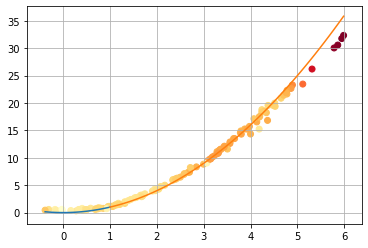

In [22]:
N = 128
V = generator.predict(TestData.load_random(n_samples=N))
Plot('test').picture(V, discriminator.model.predict(V), alpha=1)

In [32]:
gan.save('best_gan2.h5')

In [33]:
generator.model.save('best_generator2.h5')

In [34]:
discriminator.model.save('best_discriminator2.h5')

In [28]:
d2 = tf.keras.models.load_model('best_discriminator.h5')

W1021 23:20:47.660903 43904 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1021 23:20:47.716973 43904 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1021 23:20:48.125404 43904 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


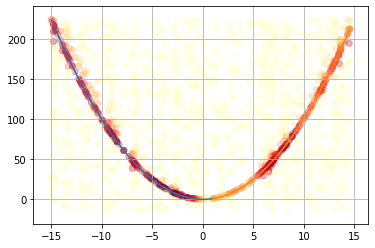

In [31]:
Plot('test2').picture(TestData.x, d2.predict(TestData.x))